In [1]:
#Read in the necessary libraries
import pandas as pd
import numpy as np
import itertools

#Matplotlib section
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

#SKLearn and Scipy Models
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Import for the creation and visualization of decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.metrics import make_scorer

#Import for random forest modeling
from sklearn.ensemble import RandomForestClassifier

In [2]:
import xgboost as xgb

#This code prevents the kernel from stopping when XGBoost is running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [3]:
#Run this cell to hide warnings about package updates
import warnings
warnings.filterwarnings('ignore')

In [4]:
#I import pickle to save certain models
import pickle

In [5]:
#A function that takes in a model and a string with the model name and saves it to the repository
def make_pickle(model, model_name):
    model_pickle_path = 'Classification_Models_After_'+ model_name + '.pkl'
    # Create a variable to pickle and open it in write mode
    model_pickle = open(model_pickle_path, 'wb')
    pickle.dump(model, model_pickle)
    model_pickle.close()

In [6]:
#Read in the csv file containing the datafreame
election_df = pd.read_csv('congressional_data_and_targets.csv')

## 1. Create the Boolean Target Variable

The data cleansing process was completed in the notebook titled "Census_Data_API_Work.ipynb"

In [7]:
#Creates a boolean column based on whether the district voted more for the Republican party or not (i.e. Democratic party/ Independent candidate)
election_df['Target_Presidential_R_bool'] = (election_df['Target_Presidential_R'] > election_df['Target_Presidential_D']).astype(int)


In [8]:
election_df.shape

(860, 54)

In [9]:
#Reorganize the dataframe so the target variable is on the right side and the identification cells are on the left
election_df = election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent', 'Previous_Presidential_D', 'Previous_Presidential_R', 'Target_Presidential_R_bool']]

## 2. EDA

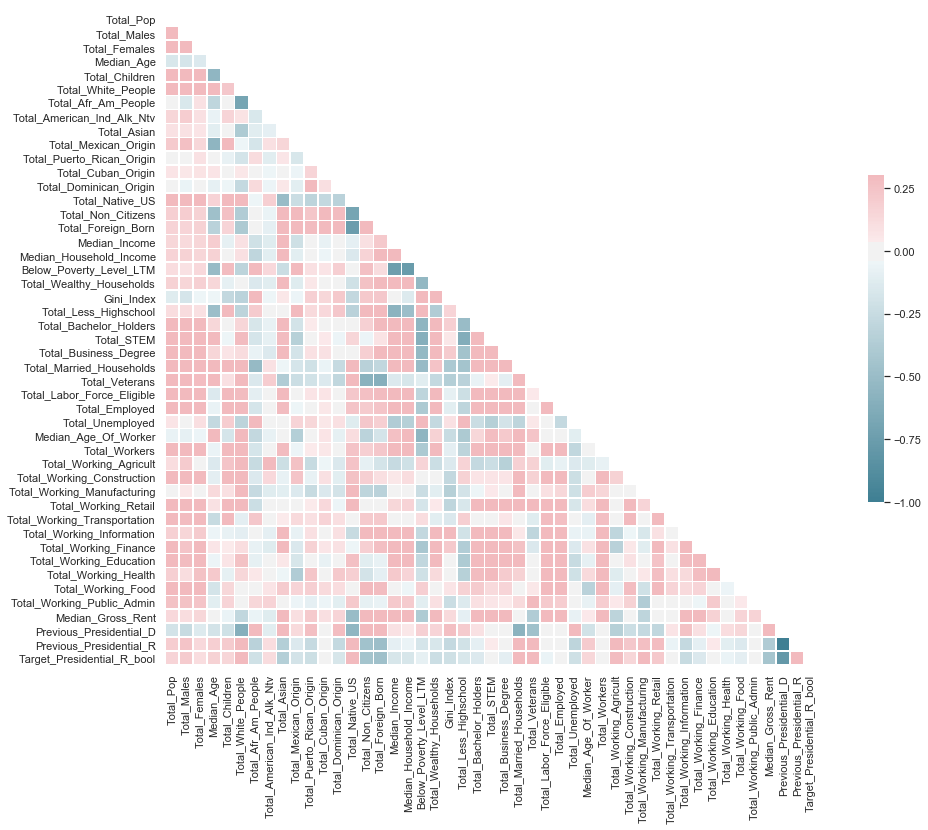

In [10]:
#This cell creates a correlation matrix to view the correlation between continuous features
#and the target variable
sns.set(style="white")

# Compute the correlation matrix
corr = election_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

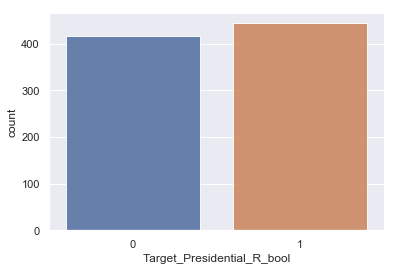

In [11]:
#A histogram of the target variable
sns.set_style('darkgrid')
sns.countplot(election_df['Target_Presidential_R_bool'], alpha=0.9)
#There is a negligible imbalance

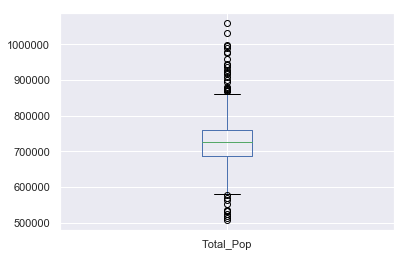

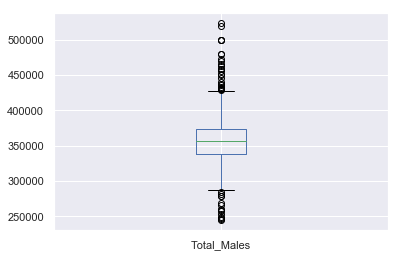

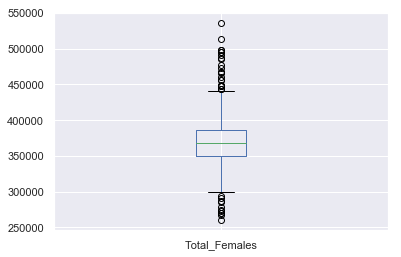

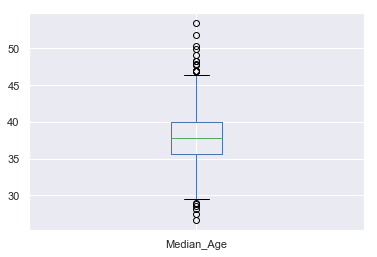

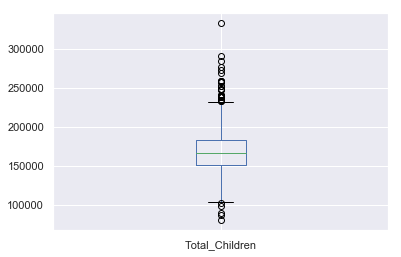

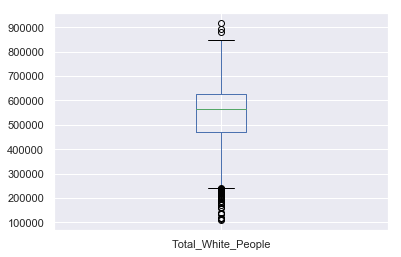

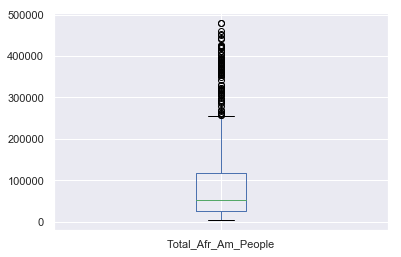

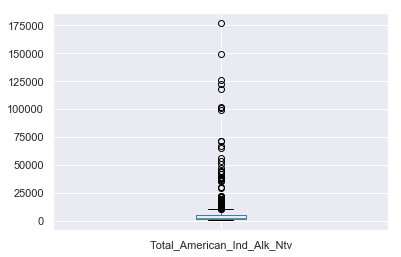

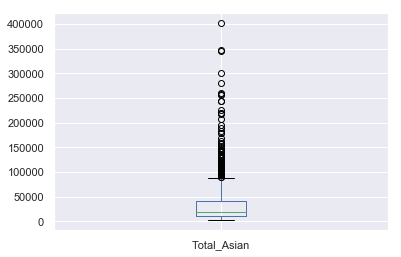

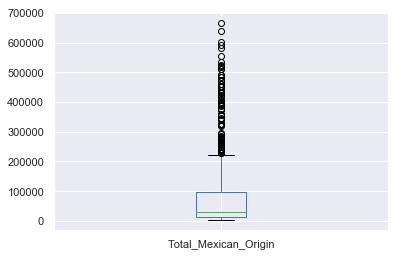

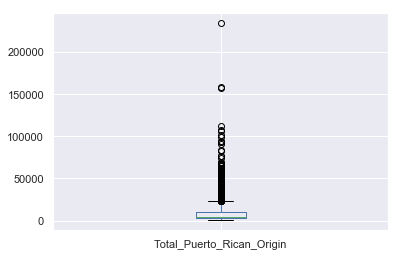

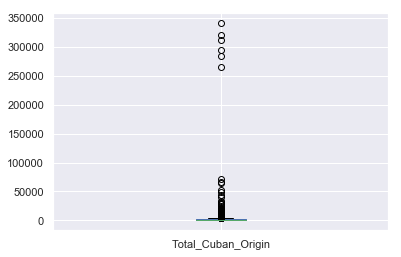

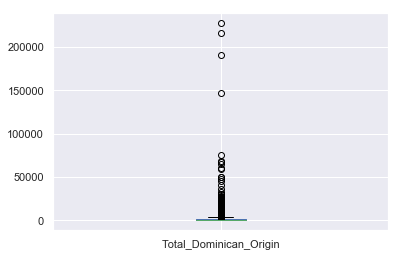

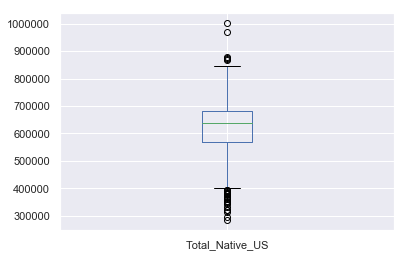

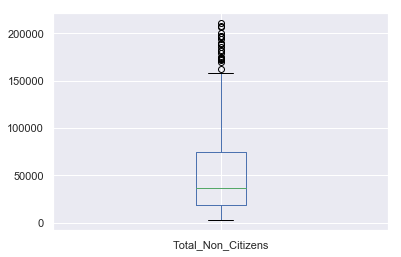

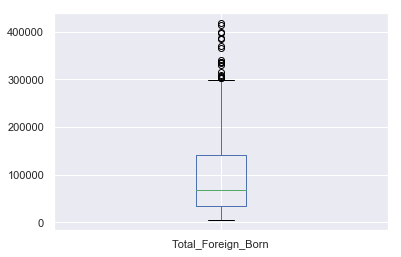

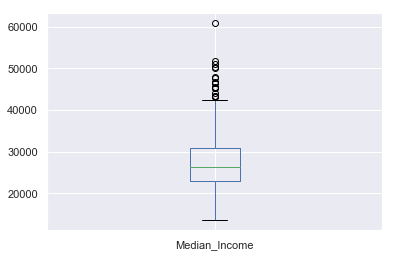

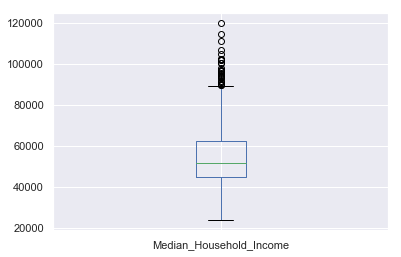

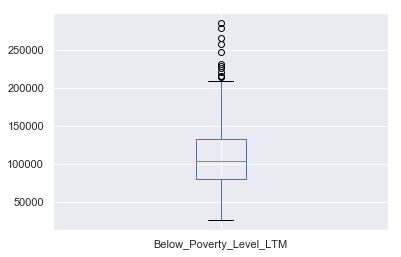

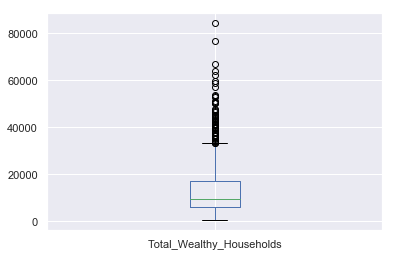

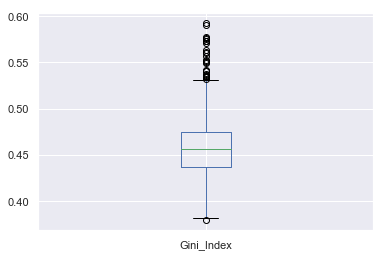

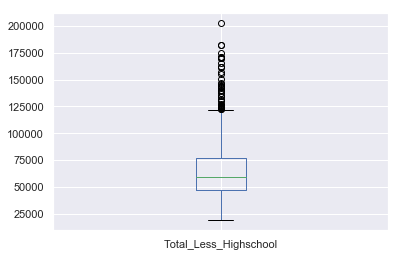

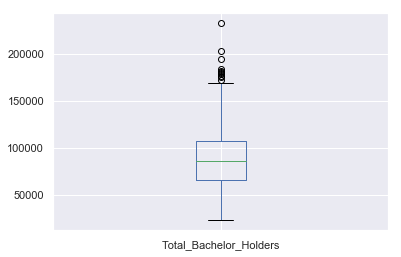

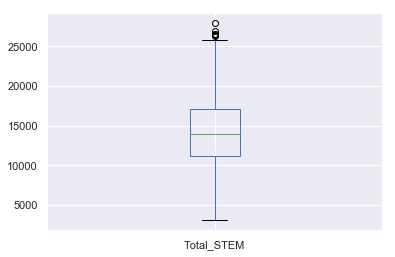

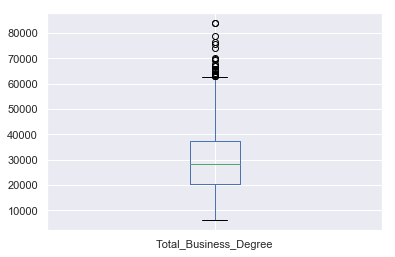

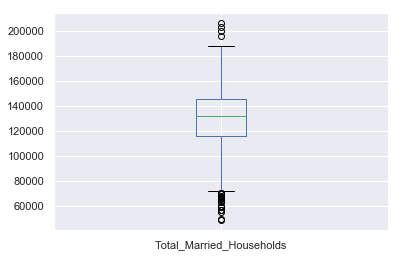

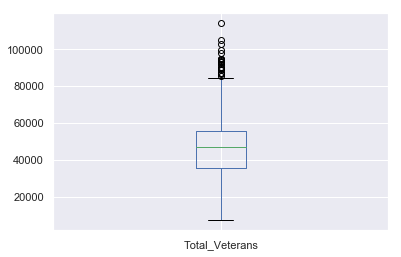

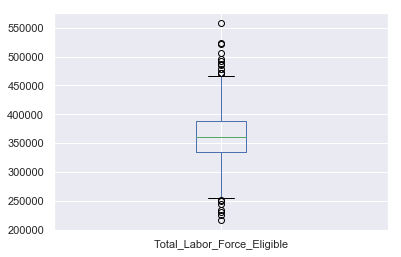

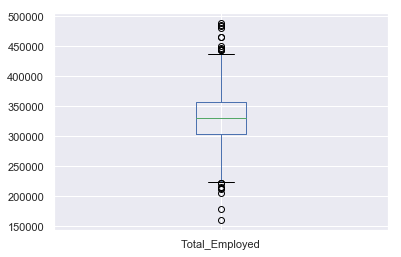

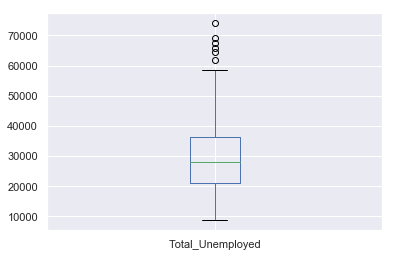

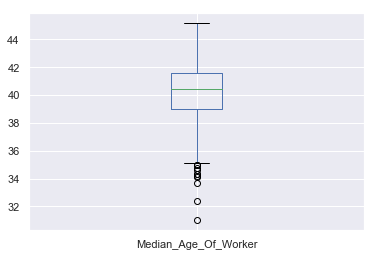

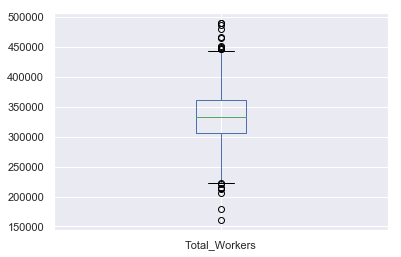

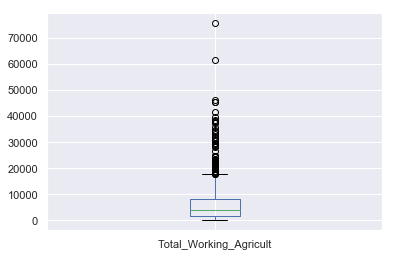

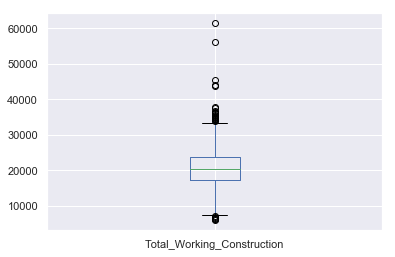

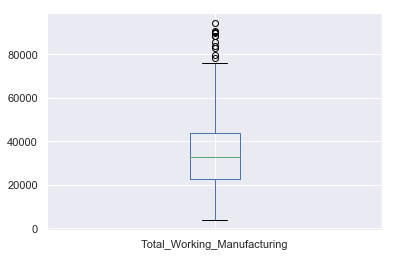

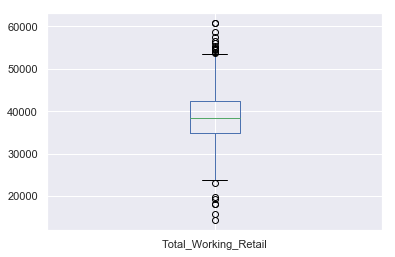

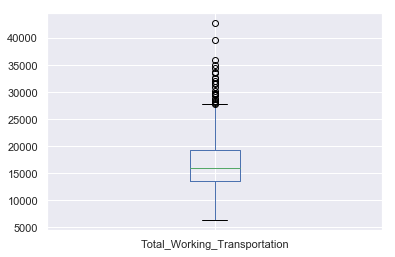

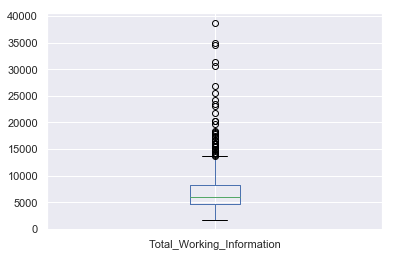

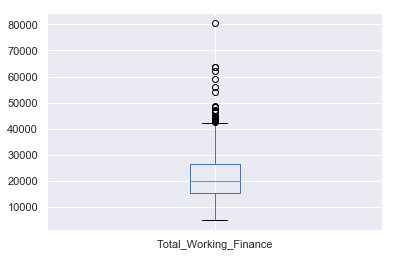

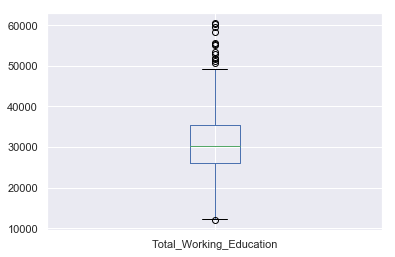

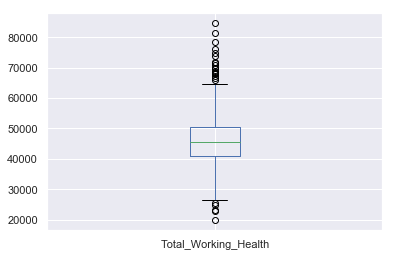

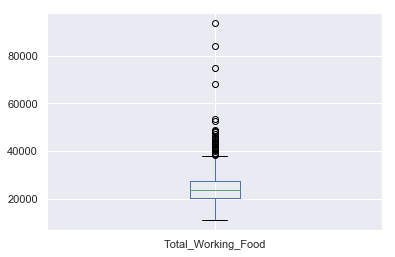

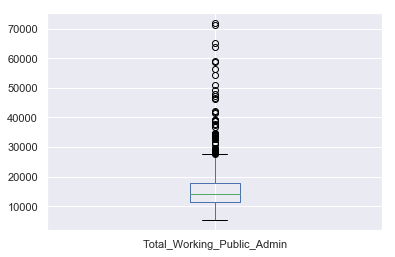

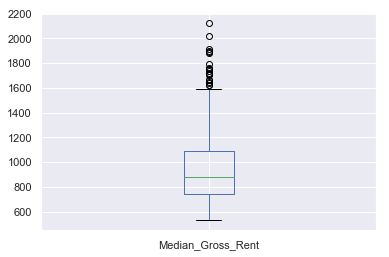

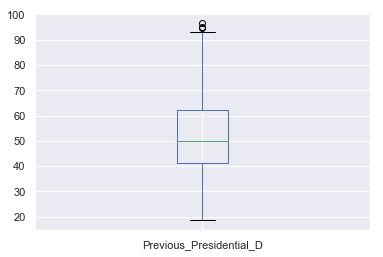

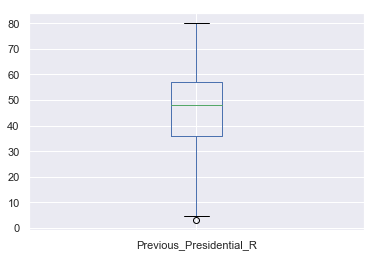

In [12]:
#Boxplots of all continuous variables as individual graphs
for i in election_df.columns[3:-1]:
    election_df.boxplot(column=i)
    plt.show()

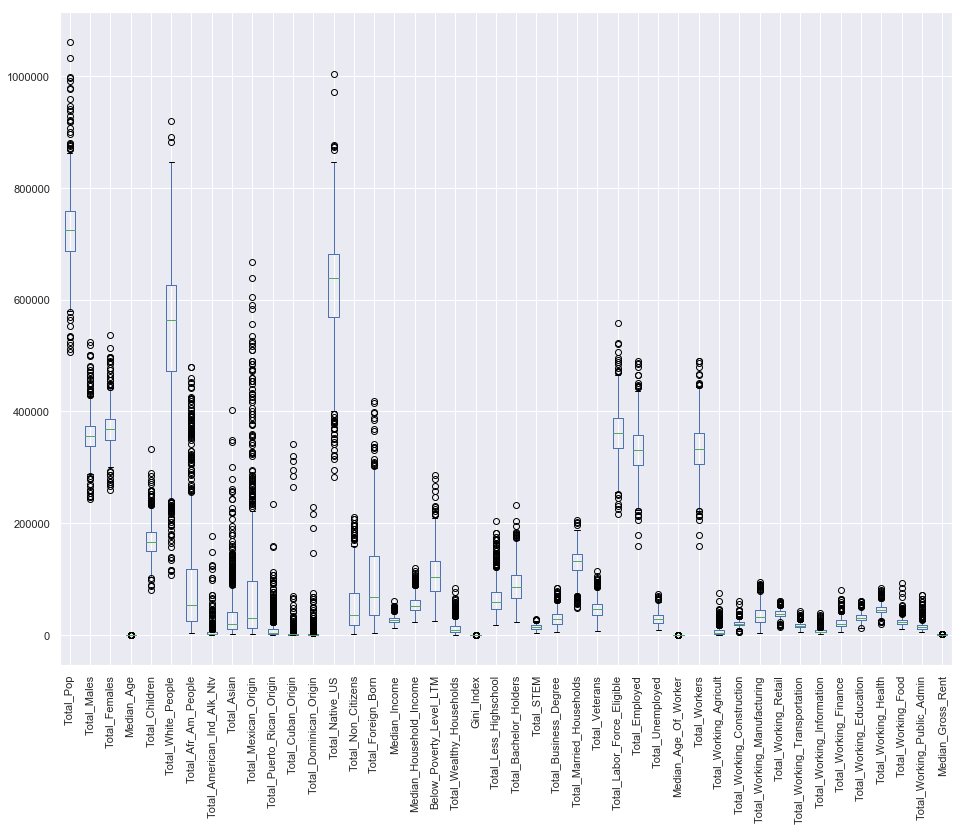

In [13]:
#A Boxplot of all continuous variables in one graph
election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent']].boxplot(figsize = (16,12), rot= 90)

## 3. Feature Engineering

In [14]:
election_df.describe()

,Total_Pop,Total_Males,Total_Females,Median_Age,Total_Children,Total_White_People,Total_Afr_Am_People,Total_American_Ind_Alk_Ntv,Total_Asian,Total_Mexican_Origin,...,Total_Working_Information,Total_Working_Finance,Total_Working_Education,Total_Working_Health,Total_Working_Food,Total_Working_Public_Admin,Median_Gross_Rent,Previous_Presidential_D,Previous_Presidential_R,Target_Presidential_R_bool
count,8.600000e+02,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,...,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000
mean,7.268451e+05,357600.737209,369244.387209,37.820233,169483.191860,533979.023256,92016.222093,5950.669767,37313.330233,80489.416279,...,7027.823256,21897.318605,30998.567442,45973.329070,24927.781395,16047.937209,941.208140,52.310209,46.105140,0.516279
std,6.619435e+04,34433.479928,33183.422698,3.590825,29622.251731,135143.070581,101111.608945,14154.258727,46828.288462,115513.394277,...,3957.953694,8880.305939,7304.605726,8275.721264,7152.465737,8063.942992,263.963379,15.197163,15.198029,0.500026
min,5.060360e+05,244165.000000,259717.000000,26.600000,79905.000000,108156.000000,3031.000000,204.000000,1582.000000,1644.000000,...,1572.000000,4898.000000,11937.000000,19790.000000,10929.000000,5196.000000,528.000000,18.500000,3.000000,0.000000
25%,6.869985e+05,338342.750000,349492.750000,35.700000,150886.250000,471771.000000,25725.000000,1466.500000,11112.250000,13003.750000,...,4568.000000,15569.250000,26153.750000,40786.000000,20498.250000,11266.750000,740.750000,41.200000,36.000000,0.000000
50%,7.251775e+05,356798.000000,367634.500000,37.800000,166010.500000,562842.000000,52870.000000,2542.000000,19595.500000,29654.500000,...,6045.000000,20156.500000,30256.500000,45551.000000,23704.500000,14209.000000,875.500000,50.000000,48.200000,1.000000
75%,7.589910e+05,374238.500000,386822.250000,40.025000,183537.500000,626446.000000,117343.500000,5004.000000,41617.000000,96621.750000,...,8227.500000,26312.750000,35481.500000,50479.500000,27580.500000,17775.500000,1092.750000,62.350000,57.200000,1.000000
max,1.060651e+06,524241.000000,536410.000000,53.500000,333258.000000,918701.000000,480259.000000,177468.000000,402466.000000,667403.000000,...,38750.000000,80628.000000,60628.000000,84767.000000,93824.000000,71974.000000,2126.000000,96.700000,80.200000,1.000000


In [15]:
#In this cell I turn subsets of the total population into percentages of the
#population and  workforce/labor force

#Identify columns to divide by population segemnts

to_divide_by_total_pop = ['Total_Males', 'Total_Females', 'Total_Veterans', 'Total_White_People', 'Total_Afr_Am_People', 'Total_Asian', 'Total_American_Ind_Alk_Ntv', 'Total_Cuban_Origin', 'Total_Puerto_Rican_Origin', 'Total_Dominican_Origin', 'Total_Mexican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Total_Children', 'Total_Married_Households', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Labor_Force_Eligible', 'Below_Poverty_Level_LTM', 'Total_Workers']
to_divide_by_total_labor_force_eligible = ['Total_Employed', 'Total_Unemployed']
to_divide_by_total_workers = ['Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Total_Working_Information']

#Normalize the data by making certain columns a percentage of one of the three main population groups

election_df[to_divide_by_total_workers] = election_df[to_divide_by_total_workers].div(election_df['Total_Workers'], axis=0)
election_df[to_divide_by_total_labor_force_eligible] = election_df[to_divide_by_total_labor_force_eligible].div(election_df['Total_Labor_Force_Eligible'], axis=0)
election_df[to_divide_by_total_pop] = election_df[to_divide_by_total_pop].div(election_df['Total_Pop'], axis=0)

In [16]:
#I create a second dataframe made of my engineered features and compare the results of
#each dataframe
election_df_feature_engineering = election_df.copy()
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Informat

In [17]:
#Create booleans if more than ten percent of a district's labor force work in a specific industry
election_df_feature_engineering['Ten_Percent_Manufacturing'] = np.where(election_df_feature_engineering['Total_Working_Manufacturing']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Manufacturing.value_counts())

election_df_feature_engineering['Ten_Percent_Agricult'] = np.where(election_df_feature_engineering['Total_Working_Agricult']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Agricult.value_counts())

election_df_feature_engineering['Ten_Percent_Construction'] = np.where(election_df_feature_engineering['Total_Working_Construction']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Construction.value_counts())

election_df_feature_engineering['Ten_Percent_Retail'] = np.where(election_df_feature_engineering['Total_Working_Retail']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Retail.value_counts())

election_df_feature_engineering['Ten_Percent_Information'] = np.where(election_df_feature_engineering['Total_Working_Information']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Information.value_counts())

election_df_feature_engineering['Ten_Percent_Transportation'] = np.where(election_df_feature_engineering['Total_Working_Transportation']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Transportation.value_counts())

election_df_feature_engineering['Ten_Percent_Finance'] = np.where(election_df_feature_engineering['Total_Working_Finance']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Finance.value_counts())

election_df_feature_engineering['Ten_Percent_Education'] = np.where(election_df_feature_engineering['Total_Working_Education']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Education.value_counts())

election_df_feature_engineering['Ten_Percent_Health'] = np.where(election_df_feature_engineering['Total_Working_Health']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Health.value_counts())

election_df_feature_engineering['Ten_Percent_Food'] = np.where(election_df_feature_engineering['Total_Working_Food']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Food.value_counts())


#Drops the columns that the above booleans were derived from
election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)


0    438
1    422
Name: Ten_Percent_Manufacturing, dtype: int64
0    847
1     13
Name: Ten_Percent_Agricult, dtype: int64
0    846
1     14
Name: Ten_Percent_Construction, dtype: int64
1    771
0     89
Name: Ten_Percent_Retail, dtype: int64
0    860
Name: Ten_Percent_Information, dtype: int64
0    853
1      7
Name: Ten_Percent_Transportation, dtype: int64
0    803
1     57
Name: Ten_Percent_Finance, dtype: int64
0    605
1    255
Name: Ten_Percent_Education, dtype: int64
1    826
0     34
Name: Ten_Percent_Health, dtype: int64
0    797
1     63
Name: Ten_Percent_Food, dtype: int64


,CD_Id_Year,District_Name,State,Total_Pop,Total_Males,Total_Females,Median_Age,Total_Children,Total_White_People,Total_Afr_Am_People,...,Ten_Percent_Manufacturing,Ten_Percent_Agricult,Ten_Percent_Construction,Ten_Percent_Retail,Ten_Percent_Information,Ten_Percent_Transportation,Ten_Percent_Finance,Ten_Percent_Education,Ten_Percent_Health,Ten_Percent_Food
0,CT-01-2016,"Congressional District 1 (114th Congress), Con...",CT,711436,0.479770,0.520230,41.0,0.207896,0.699668,0.155630,...,1,0,0,1,0,0,1,0,1,0
1,CT-02-2016,"Congressional District 2 (114th Congress), Con...",CT,709647,0.502554,0.497446,41.4,0.195105,0.853784,0.041783,...,1,0,0,1,0,0,0,1,1,0
2,CT-03-2016,"Congressional District 3 (114th Congress), Con...",CT,720493,0.482335,0.517665,39.0,0.204173,0.730279,0.132450,...,1,0,0,1,0,0,0,1,1,0
3,CT-04-2016,"Congressional District 4 (114th Congress), Con...",CT,736742,0.483697,0.516303,39.7,0.237360,0.729402,0.129932,...,0,0,0,1,0,0,1,0,1,0
4,CT-05-2016,"Congressional District 5 (114th Congress), Con...",CT,712568,0.491493,0.508507,41.8,0.217503,0.815006,0.068827,...,1,0,0,1,0,0,0,1,1,0
5,DE-AL-2016,Congressional District (at Large) (114th Congr...,DE,945934,0.484397,0.515603,39.7,0.215871,0.692336,0.215515,...,0,0,0,1,0,0,0,0,1,0
6,DC-98-2016,"Delegate District (at Large) (114th Congress),...",DC,672228,0.475590,0.524410,33.8,0.175295,0.400375,0.474290,...,0,0,0,0,0,0,0,1,0,0
7,FL-01-2016,"Congressional District 1 (114th Congress), Flo...",FL,750928,0.505951,0.494049,38.5,0.211490,0.770999,0.130881,...,0,0,0,1,0,0,0,0,1,1
8,FL-02-2016,"Congressional District 2 (114th Congress), Flo...",FL,718173,0.503203,0.496797,36.5,0.198019,0.693384,0.250157,...,0,0,0,1,0,0,0,1,1,1
9,FL-03-2016,"Congressional District 3 (114th Congress), Flo...",FL,721105,0.496932,0.503068,37.9,0.206683,0.789390,0.137008,...,0,0,0,1,0,0,0,1,1,0


In [18]:
#Drop the original columns that the threshold columns were created from
election_df_feature_engineering = election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)

#Drop the information boolean column because no district contains more than ten
#percent of the labor force working in that field
election_df_feature_engineering = election_df_feature_engineering.drop(['Ten_Percent_Information'], axis=1)

In [19]:
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Median_Gross_Rent',
       'Previous_Presidential_D', 'Previous_Presidential_R',
       'Target_Presidential_R_bool', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Per

In [20]:
#Reorganize the second dataframe
election_df_feature_engineering = election_df_feature_engineering[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Percent_Construction',
       'Ten_Percent_Retail', 'Ten_Percent_Transportation',
       'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
       'Ten_Percent_Food', 'Median_Gross_Rent',
       'Previous_Presidential_D', 'Previous_Presidential_R', 'Target_Presidential_R_bool']]

## 4. A Function To Plot The Confusion Matrix

In [21]:
#This function will be used to create confusion matrices for each model where appropriate
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    classes = ['Did Not Vote Republican', 'Voted Republican']
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix')

    figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 22})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 5. Initial Regression - Without Feature Engineering

In [22]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#Using the dataframe without feature engineering

#Split data to be used in the models between the target variable and features

# X will take every dependent variable but the target and other index variables
X_log_model_1 = election_df.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name', 'State'], axis = 1) 

#y will hold the target variable
y_log_model_1 = election_df['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [23]:
#Split the data into a train and test set
X_train_log_model_1, X_test_log_model_1, y_train_log_model_1, y_test_log_model_1 = train_test_split(X_log_model_1, y_log_model_1, random_state=1)


sc_log_model_1=StandardScaler()
X_train_scaled_log_model_1 = sc_log_model_1.fit_transform(X_train_log_model_1)
X_test_scaled_log_model_1 = sc_log_model_1.transform(X_test_log_model_1)


In [24]:
#Fit the model and view the coefficients
log_model_1 = LogisticRegression(C=1e9)
log_model_1.fit(X_train_scaled_log_model_1, y_train_log_model_1)
zip(X_train_log_model_1.columns, log_model_1.coef_[0])
log_model_1.coef_

array([[ 5.87675929e-01, -1.36862154e-01,  1.36862154e-01,
         2.47114952e-01,  8.48910799e-01,  1.29669808e+00,
        -5.20877137e+00,  6.81288740e-01,  2.99473552e-01,
        -3.48082506e+00,  2.86648156e-02, -3.65581283e-01,
         1.89335344e+00,  1.26146851e+01, -7.76060362e+00,
         1.69113041e+01,  4.06306703e+00, -1.78569254e+00,
        -2.59125464e+00, -1.67306478e+00, -4.94099737e-02,
        -3.24549234e-01,  2.84532398e+00,  5.25558700e-01,
         8.04634050e-01, -7.88163879e+00, -5.15727170e-01,
        -8.94892322e+00, -3.32358516e+00,  3.32358516e+00,
        -6.08618517e-01,  7.94801454e+00,  1.51315525e+00,
         4.45100203e+00,  6.42363786e+00,  2.95863172e+00,
         1.44636729e+00, -1.10294892e-02,  5.00348358e-01,
         1.51860795e+00,  4.04142068e-01,  2.25688429e+00,
         1.01342977e+00, -1.34592535e+00,  1.75845003e+01,
         4.13643795e+01]])

In [25]:
#Makes predictions on the train and test set
y_pred_class_log_model_1_train = log_model_1.predict(X_train_scaled_log_model_1)


#Calculate the model's accuracy and f1
print("The training accuracy is: " + str(metrics.accuracy_score(y_train_log_model_1, y_pred_class_log_model_1_train)))

print("The training f1 score is: " + str(metrics.f1_score(y_train_log_model_1, y_pred_class_log_model_1_train)))

The training accuracy is: 0.9891472868217054
The training f1 score is: 0.9896602658788775


In [26]:
#Class predictions on the test set (not predicted probabilities)
y_pred_class_log_model_1 = log_model_1.predict(X_test_scaled_log_model_1)

#Calculates the model's accuracy and f1
print("The testing accuracy is: " + str(metrics.accuracy_score(y_test_log_model_1, y_pred_class_log_model_1)))

print("The testing f1 score is: " + str(metrics.f1_score(y_test_log_model_1, y_pred_class_log_model_1)))

The testing accuracy is: 0.9209302325581395
The testing f1 score is: 0.9216589861751152


In [27]:
#Save confusion matrix and slice into four pieces
confusion_log_model_1 = metrics.confusion_matrix(y_test_log_model_1, y_pred_class_log_model_1)
TP_log_model_1 = confusion_log_model_1[1][1]
TN_log_model_1 = confusion_log_model_1[0][0]
FP_log_model_1 = confusion_log_model_1[0][1]
FN_log_model_1 = confusion_log_model_1[1][0]

print('Log Model 1 Confusion Matrix:')
print ('True Positives:', TP_log_model_1)
print ('True Negatives:', TN_log_model_1)
print ('False Positives:', FP_log_model_1)
print ('False Negatives:', FN_log_model_1)

Log Model 1 Confusion Matrix:
True Positives: 100
True Negatives: 98
False Positives: 10
False Negatives: 7


Confusion Matrix


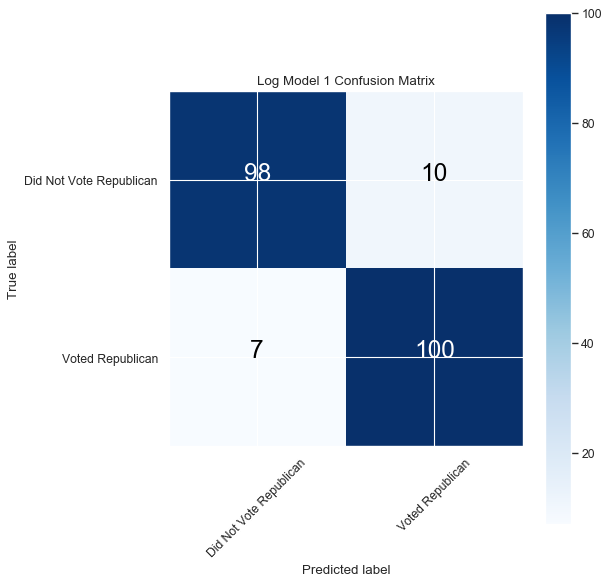

In [28]:
#Plot the confusion matrix
plot_confusion_matrix(confusion_log_model_1,
                          normalize=False,
                          title='Log Model 1 Confusion Matrix',
                          cmap=plt.cm.Blues)

## 6. Initial Regression - With Feature Engineering

In [29]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#using the dataframe with feature engineering

#Split data to be used in the models between the target variable and features

# X will take every dependent variable but the target and other index variables
X_log_model_2 = election_df_feature_engineering.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name','State'], axis = 1) 

# Create target variable
y_log_model_2 = election_df_feature_engineering['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [30]:
#Split the data into a train and test set
X_train_log_model_2, X_test_log_model_2, y_train_log_model_2, y_test_log_model_2 = train_test_split(X_log_model_2, y_log_model_2, random_state=1)


sc_log_model_2=StandardScaler()
X_train_scaled_log_model_2 = sc_log_model_2.fit_transform(X_train_log_model_2)
X_test_scaled_log_model_2 = sc_log_model_2.transform(X_test_log_model_2)


In [31]:
#Fit the model and view the coefficients
log_model_2 = LogisticRegression(C=1e9)
log_model_2.fit(X_train_scaled_log_model_2, y_train_log_model_2)
zip(X_train_log_model_2.columns, log_model_2.coef_[0])
log_model_2.coef_

array([[ 1.07596955e-01,  3.55265216e-01, -3.55265216e-01,
         1.31598783e+00,  3.13377924e-01, -1.43367222e-01,
        -3.91141051e+00, -5.29581930e-01,  1.26525823e+00,
        -2.03527558e+00, -1.15293961e+00,  2.85879698e-01,
         2.15720767e+00,  8.33984953e+00, -4.60255202e-02,
         5.75034779e+00,  1.29290743e+00, -3.05502912e+00,
        -2.42277489e+00, -2.91910921e-01, -9.52335503e-01,
        -2.17816094e+00, -1.48901406e-01, -6.39535587e-01,
        -8.25372492e-01, -2.89552563e+00, -2.04290224e+00,
        -1.13951164e+01, -3.01038041e+00,  3.01038041e+00,
        -9.11945715e-01,  1.14456603e+01, -4.50416665e-01,
        -5.30014013e-01, -5.50768514e-01,  1.42139999e+00,
         3.62388446e-01,  2.47947347e-01,  7.00311978e-02,
         1.60442759e-01,  3.12095615e-01, -6.27258142e-01,
         3.80471253e+01,  5.69332469e+01]])

In [32]:
#Makes predictions on the train and test set
y_pred_class_log_model_2_train = log_model_2.predict(X_train_scaled_log_model_2)


#Calculate the model's accuracy and f1 score
print("The training accuracy is: ", metrics.accuracy_score(y_train_log_model_2, y_pred_class_log_model_2_train))

print("The training f1 score is: ", metrics.f1_score(y_train_log_model_2, y_pred_class_log_model_2_train))

The training accuracy is:  0.9829457364341085
The training f1 score is:  0.983751846381093


In [33]:
#Class predictions on the test set (not predicted probabilities)
y_pred_class_log_model_2 = log_model_2.predict(X_test_scaled_log_model_2)

#Calculate the model's accuracy and f1 score
print("The testing accuracy is: ", metrics.accuracy_score(y_test_log_model_2, y_pred_class_log_model_2))

print("The testing f1 score is: ", metrics.f1_score(y_test_log_model_2, y_pred_class_log_model_2))

The testing accuracy is:  0.9116279069767442
The testing f1 score is:  0.9124423963133641


In [34]:
#Save confusion matrix and slice into four pieces
confusion_log_model_2 = metrics.confusion_matrix(y_test_log_model_2, y_pred_class_log_model_2)
TP_log_model_2 = confusion_log_model_1[1][1]
TN_log_model_2 = confusion_log_model_1[0][0]
FP_log_model_2 = confusion_log_model_1[0][1]
FN_log_model_2 = confusion_log_model_1[1][0]

print('Log Model 2 Confusion Matrix:')
print ('True Positives:', TP_log_model_2)
print ('True Negatives:', TN_log_model_2)
print ('False Positives:', FP_log_model_2)
print ('False Negatives:', FN_log_model_2)

Log Model 2 Confusion Matrix:
True Positives: 100
True Negatives: 98
False Positives: 10
False Negatives: 7


Confusion Matrix


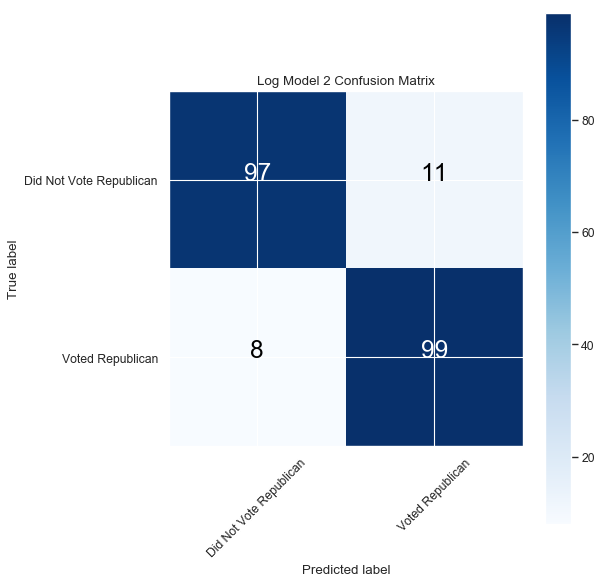

In [35]:
#Plot the confusion Matrix
plot_confusion_matrix(confusion_log_model_2,
                          normalize=False,
                          title='Log Model 2 Confusion Matrix',
                          cmap=plt.cm.Blues)

## 7. Logistic Model Grid Search

In [36]:
#The following is a function that resets the data for future use
def reset_data(df_to_use = None):
    
    if df_to_use == 'engineered':
        
        df = election_df_feature_engineering
        
        features_list = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
                         'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
                         'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
                         'Median_Household_Income', 'Below_Poverty_Level_LTM',
                         'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
                         'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
                         'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
                         'Ten_Percent_Agricult', 'Ten_Percent_Construction',
                         'Ten_Percent_Retail', 'Ten_Percent_Transportation',
                         'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
                         'Ten_Percent_Food', 'Median_Gross_Rent',
                         'Previous_Presidential_D', 'Previous_Presidential_R']
    else:
        
        df = election_df
        
        features_list = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin',
                         'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens',
                         'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income',
                         'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index',
                         'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM',
                         'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
                         'Total_Working_Construction', 'Total_Working_Manufacturing',
                         'Total_Working_Retail', 'Total_Working_Transportation',
                         'Total_Working_Information', 'Total_Working_Finance', 
                         'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
                         'Total_Working_Public_Admin', 'Median_Gross_Rent', 'Previous_Presidential_D',
                         'Previous_Presidential_R']
    
    y = df.Target_Presidential_R_bool
    X = df[features_list]
    
    return train_test_split(X, y, random_state=1, test_size = 0.2)


In [37]:
#Splits the data for the logistic model gridsearch, using the standard features
X_train_log_model_3, X_test_log_model_3, y_train_log_model_3, y_test_log_model_3 =  reset_data()

sc_log_model_3=StandardScaler()
X_train_scaled_log_model_3= sc_log_model_3.fit_transform(X_train_log_model_3)
X_test_scaled_log_model_3 = sc_log_model_3.transform(X_test_log_model_3)

In [38]:
# Creates logistic regression model
log_model_3 = linear_model.LogisticRegression()

In [39]:
# Creates regularization penalty parameters
penalty = ['l1', 'l2']

# Creates regularization hyperparameters
C = C_param_range = [0.001,0.01,0.1, 0.5, 1, 2, 5, 10]

# Creates hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [40]:
# Creates a grid search using 5-fold cross validation
clf_gs_log_model_3 = GridSearchCV(log_model_3, hyperparameters, cv=5, scoring= "f1") 

In [41]:
# Fits grid search to the training data
log_model_3 = clf_gs_log_model_3.fit(X_train_scaled_log_model_3, y_train_log_model_3) 

In [42]:
# View best hyperparameters
print('Best Penalty:', log_model_3.best_estimator_.get_params()['penalty'])
print('Best C:', log_model_3.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 0.1


In [43]:
#Make predictions for scoring purposes
y_pred_train_log_model_3 = log_model_3.best_estimator_.predict(X_train_scaled_log_model_3)

y_pred_test_log_model_3 = log_model_3.best_estimator_.predict(X_test_scaled_log_model_3)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 3 (GS Standard Features):", metrics.accuracy_score(y_train_log_model_3, y_pred_train_log_model_3))
print("Training F1 Score for Log Model 3 (GS Standard Features):", metrics.f1_score(y_train_log_model_3, y_pred_train_log_model_3))
print("")
print("Testing Accuracy for Log Model 3 (GS Standard Features):", metrics.accuracy_score(y_test_log_model_3, y_pred_test_log_model_3))
print("Testing F1 Score for Log Model 3 (GS Standard Features):", metrics.f1_score(y_test_log_model_3, y_pred_test_log_model_3))

Training Accuracy for Log Model 3 (GS Standard Features): 0.9578488372093024
Training F1 Score for Log Model 3 (GS Standard Features): 0.9593267882187938

Testing Accuracy for Log Model 3 (GS Standard Features): 0.9127906976744186
Testing F1 Score for Log Model 3 (GS Standard Features): 0.9206349206349207


In [44]:
# Sorts feature importances in descending order and displays the top 10

model_params_log_model_3 = list(zip(list(X_train_log_model_3.columns), log_model_3.best_estimator_.coef_[0]))

model_params_log_model_3.sort(key = lambda x: abs(x[1]), reverse=True)
model_params_log_model_3[:10]

[('Previous_Presidential_R', 4.530569801032099),
 ('Median_Gross_Rent', -0.413633399556793),
 ('Total_Non_Citizens', -0.31841974264467465),
 ('Total_Working_Finance', -0.1391313995795773),
 ('Total_Wealthy_Households', -0.1122085799694822),
 ('Total_Working_Retail', 0.10457360466079489),
 ('Total_Working_Manufacturing', 0.07731871683638847),
 ('Total_Mexican_Origin', -0.07305460322448006),
 ('Previous_Presidential_D', -0.02606084081353116),
 ('Total_Pop', 0.0)]

<Figure size 432x288 with 0 Axes>

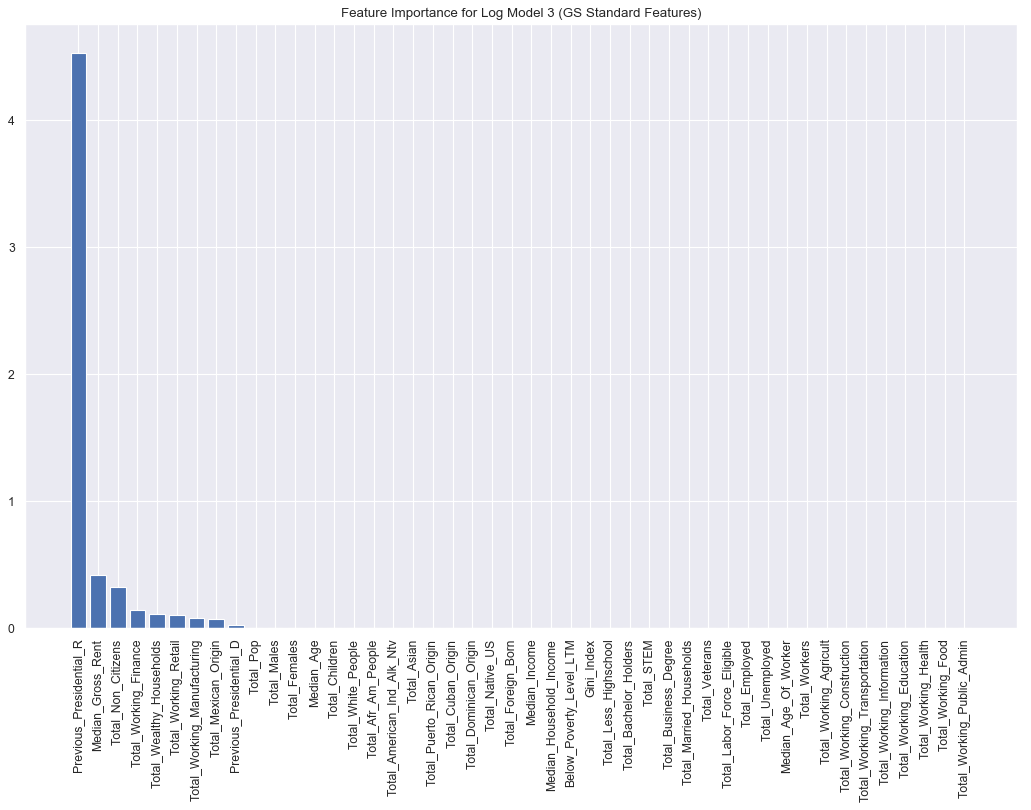

In [45]:
#Plots the parameter importance

# Rearrange feature names so they match the sorted feature importances
model_features_log_model_3 = [i[0] for i in model_params_log_model_3]

feature_weights_log_model_3 = [abs(i[1]) for i in model_params_log_model_3]

# Creates the plot

plt.figure()
figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# Creates the plot title
plt.title("Feature Importance for Log Model 3 (GS Standard Features)")

# Add bars
plt.bar(model_features_log_model_3, feature_weights_log_model_3)

# Add feature names as x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

In [46]:
# View confusion matrix and slice into four pieces

confusion_log_model_3 = metrics.confusion_matrix(y_test_log_model_3, y_pred_test_log_model_3)
TP_log_model_3 = confusion_log_model_3[1][1]
TN_log_model_3 = confusion_log_model_3[0][0]
FP_log_model_3 = confusion_log_model_3[0][1]
FN_log_model_3 = confusion_log_model_3[1][0]

print('Log Model 3 Confusion Matrix:')
print ('True Positives:', TP_log_model_3)
print ('True Negatives:', TN_log_model_3)
print ('False Positives:', FP_log_model_3)
print ('False Negatives:', FN_log_model_3)

Log Model 3 Confusion Matrix:
True Positives: 87
True Negatives: 70
False Positives: 10
False Negatives: 5


Confusion Matrix


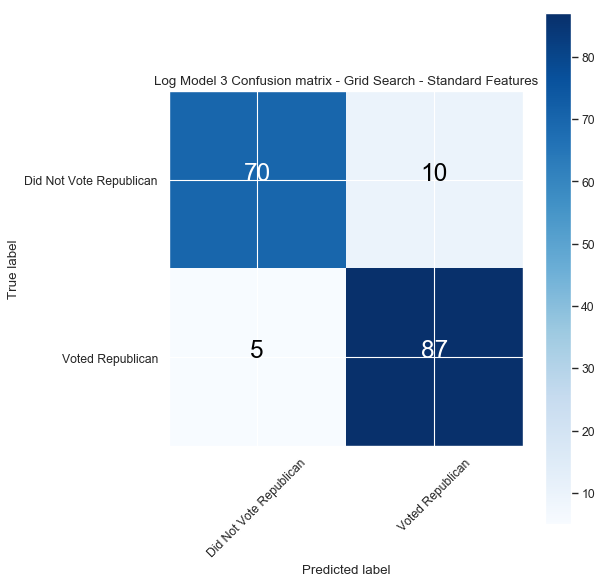

In [47]:
#Plots the confusion matrix visualization
confusion_log_model_3 = metrics.confusion_matrix(y_test_log_model_3, y_pred_test_log_model_3)

plot_confusion_matrix(confusion_log_model_3, title='Log Model 3 Confusion matrix - Grid Search - Standard Features')


## 8. Logistic Model Grid Search With Engineered Features

In [48]:
#Splits the data for the logistic model gridsearch, using the engineered features
X_train_log_model_4, X_test_log_model_4, y_train_log_model_4, y_test_log_model_4 =  reset_data('engineered')

sc_log_model_4=StandardScaler()
X_train_scaled_log_model_4= sc_log_model_4.fit_transform(X_train_log_model_4)
X_test_scaled_log_model_4 = sc_log_model_4.transform(X_test_log_model_4)

# Create logistic regression model
log_model_4 = linear_model.LogisticRegression()

# Create grid search using 5-fold cross validation, same parameters as before
clf_gs_log_model_4 = GridSearchCV(log_model_4, hyperparameters, cv=5, scoring= "f1") 

# Fit grid search
log_model_4 = clf_gs_log_model_4.fit(X_train_scaled_log_model_4, y_train_log_model_4)



In [49]:
# View best hyperparameters
print('Best Penalty:', log_model_4.best_estimator_.get_params()['penalty'])
print('Best C:', log_model_4.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 0.5


In [50]:
#Make predictions for scoring purposes

y_pred_train_log_model_4 = log_model_4.best_estimator_.predict(X_train_scaled_log_model_4)

y_pred_test_log_model_4 = log_model_4.best_estimator_.predict(X_test_scaled_log_model_4)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 4 (GS Engineered Features):", metrics.accuracy_score(y_train_log_model_4, y_pred_train_log_model_4))
print("Training F1 Score for Log Model 4 (GS Engineered Features):", metrics.f1_score(y_train_log_model_4, y_pred_train_log_model_4))
print("")
print("Testing Accuracy for Log Model 4 (GS Engineered Features):", metrics.accuracy_score(y_test_log_model_4, y_pred_test_log_model_4))
print("Testing F1 Score for Log Model 4 (GS Engineered Features):", metrics.f1_score(y_test_log_model_4, y_pred_test_log_model_4))

Training Accuracy for Log Model 4 (GS Engineered Features): 0.9651162790697675
Training F1 Score for Log Model 4 (GS Engineered Features): 0.9660056657223796

Testing Accuracy for Log Model 4 (GS Engineered Features): 0.9011627906976745
Testing F1 Score for Log Model 4 (GS Engineered Features): 0.9081081081081082


In [51]:
# Sorts feature importances in descending order and displays the top 10

model_params_log_model_4 = list(zip(list(X_train_log_model_4.columns), log_model_4.best_estimator_.coef_[0]))

model_params_log_model_4.sort(key = lambda x: abs(x[1]), reverse=True)
model_params_log_model_4[:10]

[('Previous_Presidential_R', 7.4915988782069345),
 ('Ten_Percent_Retail', 0.6028204079792449),
 ('Median_Gross_Rent', -0.5489006072695054),
 ('Total_Mexican_Origin', -0.4979131908762806),
 ('Total_Bachelor_Holders', -0.4103439136855904),
 ('Gini_Index', -0.3419491943696862),
 ('Total_Non_Citizens', -0.30290382079667144),
 ('Total_Wealthy_Households', -0.21091890281930722),
 ('Median_Age', 0.12720834263492437),
 ('Total_Puerto_Rican_Origin', -0.1252738602280384)]

<Figure size 432x288 with 0 Axes>

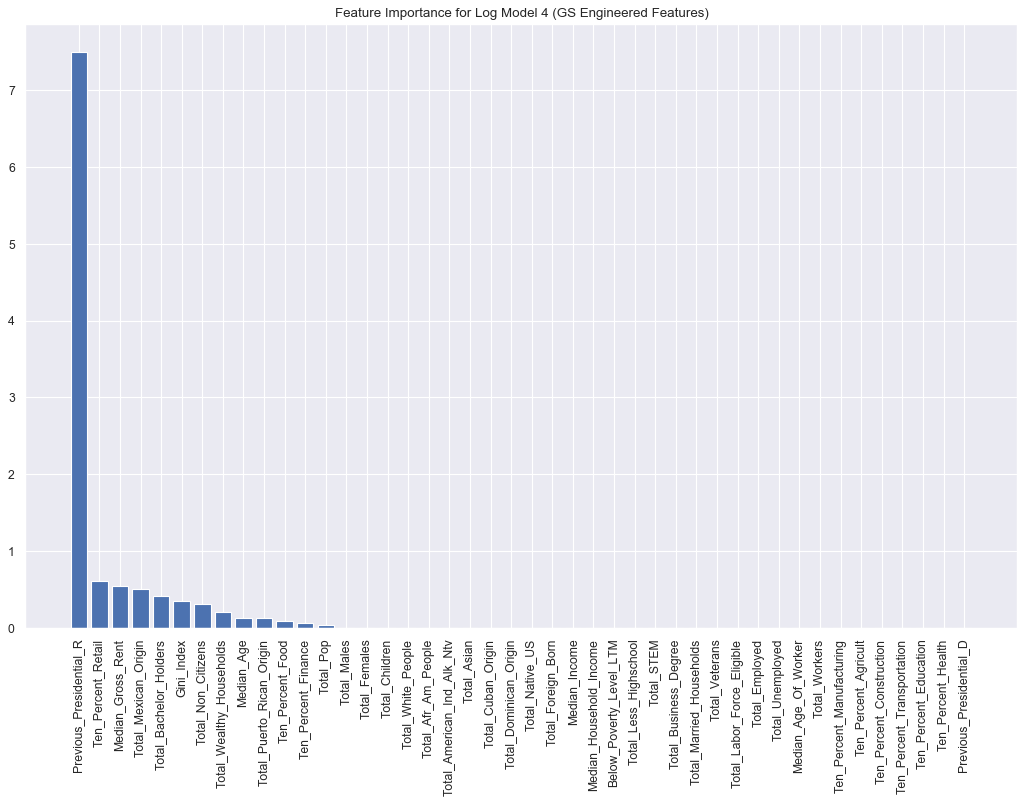

In [52]:
#Plot the parameter importance

# Rearrange feature names so they match the sorted feature importances
model_features_log_model_4 = [i[0] for i in model_params_log_model_4]

feature_weights_log_model_4 = [abs(i[1]) for i in model_params_log_model_4]

# Create plot

plt.figure()
figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# Create plot title
plt.title("Feature Importance for Log Model 4 (GS Engineered Features)")

# Add bars
plt.bar(model_features_log_model_4, feature_weights_log_model_4)

# Add feature names as x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

Confusion Matrix


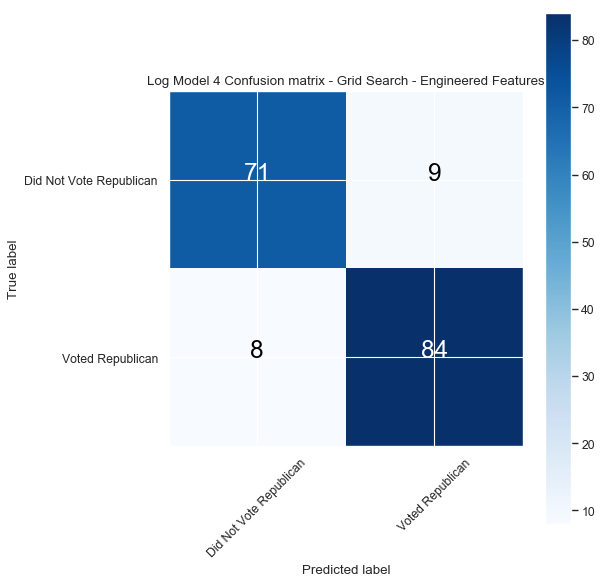

In [53]:
#View the confusion matrix
confusion_log_model_4 = metrics.confusion_matrix(y_test_log_model_4, y_pred_test_log_model_4)
plot_confusion_matrix(confusion_log_model_4, title='Log Model 4 Confusion matrix - Grid Search - Engineered Features')

## 9. Logistic Model Grid Search On The Standard Set- With Polynomials

In [54]:
#Create a pipeline for a polynomial grid search
pipe_lr_poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
            ('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

In [55]:
#Sets up the parameters to search through
penalty_param_range_lr_poly = [1.0, 0.5, 0.1, .01]

grid_params_lr_poly = [{'clf__penalty': ['l1', 'l2'], 'clf__C': penalty_param_range_lr_poly, 'clf__solver': ['liblinear']}] 



In [56]:
#Splits the data for the polynomial logistic model gridsearch, using the standard features
X_train_log_model_5, X_test_log_model_5, y_train_log_model_5, y_test_log_model_5 =  reset_data()

sc_log_model_5=StandardScaler()
X_train_scaled_log_model_5= sc_log_model_5.fit_transform(X_train_log_model_5)
X_test_scaled_log_model_5 = sc_log_model_5.transform(X_test_log_model_5)

In [57]:
#Fits the model
log_model_5 = GridSearchCV(estimator=pipe_lr_poly, param_grid=grid_params_lr_poly, scoring='f1', cv=10)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
log_model_5.fit(X_train_scaled_log_model_5, y_train_log_model_5)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 0.5, 0.1, 0.01], 'clf__solver': ['liblinear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [58]:
#Loading the saved model with pickle
#log_model_5_pkl = open('./Classification_Models_After_log_model_5.pkl', 'rb')
#log_model_5 = pickle.load(log_model_5_pkl)
#print("Loaded log_model_5 Pickle :: ", log_model_5)

In [59]:
# Best params
print('Best params: %s' % log_model_5.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % log_model_5.best_score_)
# Predict on test data with best params
y_pred_test_log_model_5 = log_model_5.predict(X_test_scaled_log_model_5)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_log_model_5, y_pred_test_log_model_5))

Best params: {'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.953
Test set F1 score for best params: 0.9215 


In [60]:
#Make predictions for scoring purposes
y_pred_train_log_model_5 = log_model_5.predict(X_train_scaled_log_model_5)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 5 (GS Polynomials Standard Features):", accuracy_score(y_train_log_model_5, y_pred_train_log_model_5))
print("Training F1 Score for Log Model 5 (GS Polynomials Standard Features):", f1_score(y_train_log_model_5, y_pred_train_log_model_5))
print("")
print("Testing Accuracy for Log Model 5 (GS Polynomials Standard Features):", accuracy_score(y_test_log_model_5, y_pred_test_log_model_5))
print("Testing F1 Score for Log Model 5 (GS Polynomials Standard Features):", f1_score(y_test_log_model_5, y_pred_test_log_model_5))

Training Accuracy for Log Model 5 (GS Polynomials Standard Features): 0.997093023255814
Training F1 Score for Log Model 5 (GS Polynomials Standard Features): 0.9971590909090909

Testing Accuracy for Log Model 5 (GS Polynomials Standard Features): 0.9127906976744186
Testing F1 Score for Log Model 5 (GS Polynomials Standard Features): 0.9214659685863874


Confusion Matrix


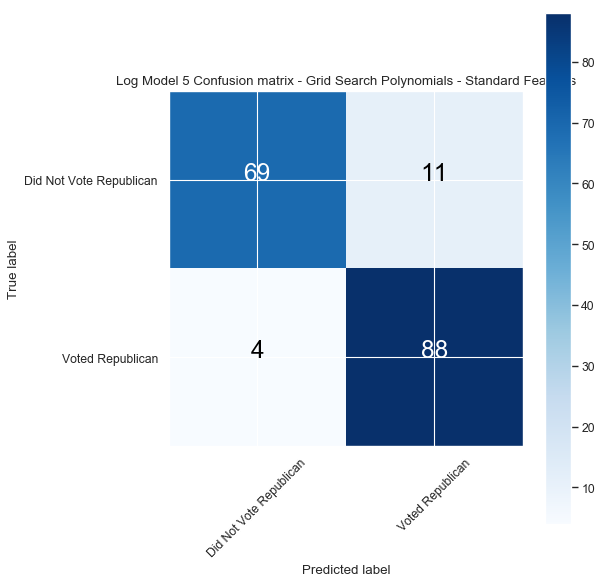

In [61]:
#View the confusion matrix
confusion_log_model_5 = metrics.confusion_matrix(y_test_log_model_5, y_pred_test_log_model_5)
plot_confusion_matrix(confusion_log_model_5, title='Log Model 5 Confusion matrix - Grid Search Polynomials - Standard Features')

In [62]:
#Run this code to save the model data
#make_pickle(log_model_5, 'log_model_5')

## 10. Logistic Model Grid Search On The Engineered Set- With Polynomials

In [63]:
#Splits the data for the polynomial logistic model gridsearch, using the engineered features
X_train_log_model_6, X_test_log_model_6, y_train_log_model_6, y_test_log_model_6 =  reset_data('engineered')

sc_log_model_6=StandardScaler()
X_train_scaled_log_model_6= sc_log_model_6.fit_transform(X_train_log_model_6)
X_test_scaled_log_model_6 = sc_log_model_6.transform(X_test_log_model_6)

In [64]:
log_model_6 = GridSearchCV(estimator=pipe_lr_poly, param_grid=grid_params_lr_poly, scoring='f1', cv=10)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
log_model_6.fit(X_train_scaled_log_model_6, y_train_log_model_6)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 0.5, 0.1, 0.01], 'clf__solver': ['liblinear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [65]:
#Loading the saved polynomial logistic model with pickle
#log_model_6_pkl = open('./Classification_Models_After_log_model_6.pkl', 'rb')
#log_model_6 = pickle.load(log_model_6_pkl)
#print("Loaded log_model_6 Pickle :: ", log_model_6)

In [66]:
# Best params
print('Best params: %s' % log_model_6.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % log_model_5.best_score_)
# Predict on test data with best params
y_pred_test_log_model_6 = log_model_6.predict(X_test_scaled_log_model_6)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_log_model_6, y_pred_test_log_model_6))

Best params: {'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.953
Test set F1 score for best params: 0.9312 


In [67]:
#Make predictions for scoring purposes
y_pred_train_log_model_6 = log_model_6.predict(X_train_scaled_log_model_6)

# Prints the accuracy and f1 scores
print("Training Accuracy for Log Model 6 (GS Polynomials Engineered Features):", accuracy_score(y_train_log_model_6, y_pred_train_log_model_6))
print("Training F1 Score for Log Model 6 (GS Polynomials Engineered Features):", f1_score(y_train_log_model_6, y_pred_train_log_model_6))
print("")
print("Testing Accuracy for Log Model 6 (GS Polynomials Engineered Features):", accuracy_score(y_test_log_model_6, y_pred_test_log_model_6))
print("Testing F1 Score for Log Model 6 (GS Polynomials Engineered Features):", f1_score(y_test_log_model_6, y_pred_test_log_model_6))

Training Accuracy for Log Model 6 (GS Polynomials Engineered Features): 0.9927325581395349
Training F1 Score for Log Model 6 (GS Polynomials Engineered Features): 0.9929078014184397

Testing Accuracy for Log Model 6 (GS Polynomials Engineered Features): 0.9244186046511628
Testing F1 Score for Log Model 6 (GS Polynomials Engineered Features): 0.9312169312169312


Confusion Matrix


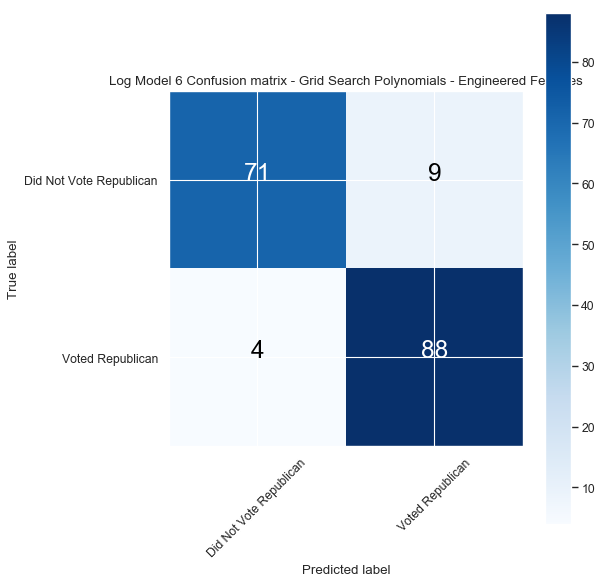

In [68]:
#View the confusion matrix
confusion_log_model_6 = metrics.confusion_matrix(y_test_log_model_6, y_pred_test_log_model_6)
plot_confusion_matrix(confusion_log_model_6, title='Log Model 6 Confusion matrix - Grid Search Polynomials - Engineered Features')

In [69]:
#Run this code to save the model data
#make_pickle(log_model_6, 'log_model_6')

## 11. KNN - Standard Set

In [70]:
#Splits the data for the KNN model gridsearch, using the standard features
X_train_KNN_model_1, X_test_KNN_model_1, y_train_KNN_model_1, y_test_KNN_model_1 =  reset_data()

sc_KNN_model_1=StandardScaler()
X_train_scaled_KNN_model_1= sc_KNN_model_1.fit_transform(X_train_KNN_model_1)
X_test_scaled_KNN_model_1 = sc_KNN_model_1.transform(X_test_KNN_model_1)

In [71]:
#Creates a pipeline of parameters for the KNN model
pipe_KNN_poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
            ('scl', StandardScaler()),
            ('knn', KNeighborsClassifier())])

In [72]:
#Creates parameters for the KNN model
neighbors= list(range(1,20,2))
grid_params_KNN = [{'knn__n_neighbors':neighbors, 'knn__weights': ['uniform', 'distance']}] 

In [73]:
#Creates the KNN model
KNN_model_1 = GridSearchCV(estimator=pipe_KNN_poly, param_grid=grid_params_KNN, scoring='f1',
                           cv=5)
#I've taken out the parameter 'verbose=5' to neaten up the notebook

In [74]:
#Fits the KNN model to the data
KNN_model_1.fit(X_train_scaled_KNN_model_1, y_train_KNN_model_1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'knn__weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [75]:
# Best params
print('Best params: %s' % KNN_model_1.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % KNN_model_1.best_score_)
# Predict on test data with best params
y_pred_test_KNN_model_1 = KNN_model_1.predict(X_test_scaled_KNN_model_1)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))

Best params: {'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
Best training accuracy: 0.846
Test set F1 score for best params: 0.8365 


In [76]:
# Make predictions for scoring purposes
y_pred_train_KNN_model_1 = KNN_model_1.predict(X_train_scaled_KNN_model_1)

# Prints the accuracy and f1 scores
print("Training Accuracy for KNN Model 1 (Standard Features):", accuracy_score(y_train_KNN_model_1, y_pred_train_KNN_model_1))
print("Training F1 Score for KNN Model 1 (Standard Features):", f1_score(y_train_KNN_model_1, y_pred_train_KNN_model_1))
print("")
print("Testing Accuracy for KNN Model 1 (Standard Features):", accuracy_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))
print("Testing F1 Score for KNN Model 1 (Standard Features):", f1_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))

Training Accuracy for KNN Model 1 (Standard Features): 0.877906976744186
Training F1 Score for KNN Model 1 (Standard Features): 0.888888888888889

Testing Accuracy for KNN Model 1 (Standard Features): 0.8023255813953488
Testing F1 Score for KNN Model 1 (Standard Features): 0.8365384615384616


Confusion Matrix


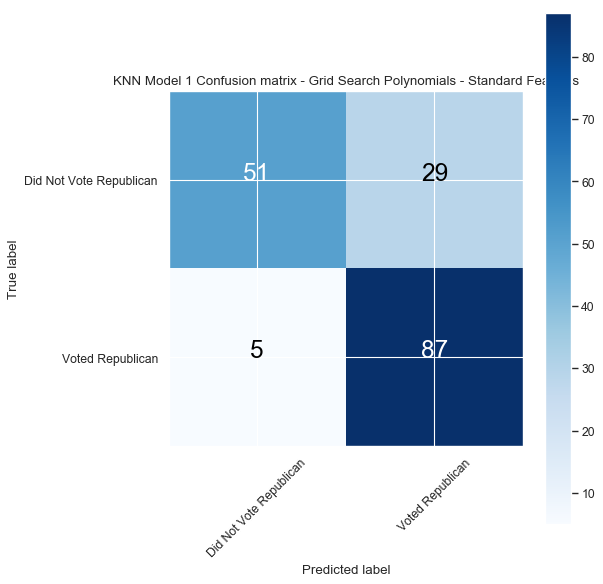

In [77]:
#Plots the confusion matrix
confusion_KNN_model_1 = metrics.confusion_matrix(y_test_KNN_model_1, y_pred_test_KNN_model_1)
plot_confusion_matrix(confusion_KNN_model_1, title='KNN Model 1 Confusion matrix - Grid Search Polynomials - Standard Features')

## 12. KNN - Engineered Features

In [78]:
#Splits the data for the KNN model gridsearch, using the engineered features
X_train_KNN_model_2, X_test_KNN_model_2, y_train_KNN_model_2, y_test_KNN_model_2 =  reset_data('engineered')

sc_KNN_model_2=StandardScaler()
X_train_scaled_KNN_model_2= sc_KNN_model_2.fit_transform(X_train_KNN_model_2)
X_test_scaled_KNN_model_2 = sc_KNN_model_2.transform(X_test_KNN_model_2)

In [79]:
#Creates the KNN model
KNN_model_2 = GridSearchCV(estimator=pipe_KNN_poly, param_grid=grid_params_KNN, scoring='f1',
                           cv=5)
#I've taken out the parameter 'verbose=5' to neaten up the notebook

In [80]:
#Fits the KNN model to the data
KNN_model_2.fit(X_train_scaled_KNN_model_2, y_train_KNN_model_2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'knn__weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [81]:
# Best params
print('Best params: %s' % KNN_model_2.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % KNN_model_2.best_score_)
# Predict on test data with best params
y_pred_test_KNN_model_2 = KNN_model_2.predict(X_test_scaled_KNN_model_2)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))

Best params: {'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
Best training accuracy: 0.845
Test set F1 score for best params: 0.8342 


In [82]:
# Make predictions for scoring purposes
y_pred_train_KNN_model_2 = KNN_model_2.predict(X_train_scaled_KNN_model_2)

# Prints the accuracy and f1 scores
print("Training Accuracy for KNN Model 2 (Engineered Features):", accuracy_score(y_train_KNN_model_2, y_pred_train_KNN_model_2))
print("Training F1 Score for KNN Model 2 (Engineered Features):", f1_score(y_train_KNN_model_2, y_pred_train_KNN_model_2))
print("")
print("Testing Accuracy for KNN Model 2 (Engineered Features):", accuracy_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))
print("Testing F1 Score for KNN Model 2 (Engineered Features):", f1_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))

Training Accuracy for KNN Model 2 (Engineered Features): 0.8997093023255814
Training F1 Score for KNN Model 2 (Engineered Features): 0.9058663028649387

Testing Accuracy for KNN Model 2 (Engineered Features): 0.8081395348837209
Testing F1 Score for KNN Model 2 (Engineered Features): 0.8341708542713568


Confusion Matrix


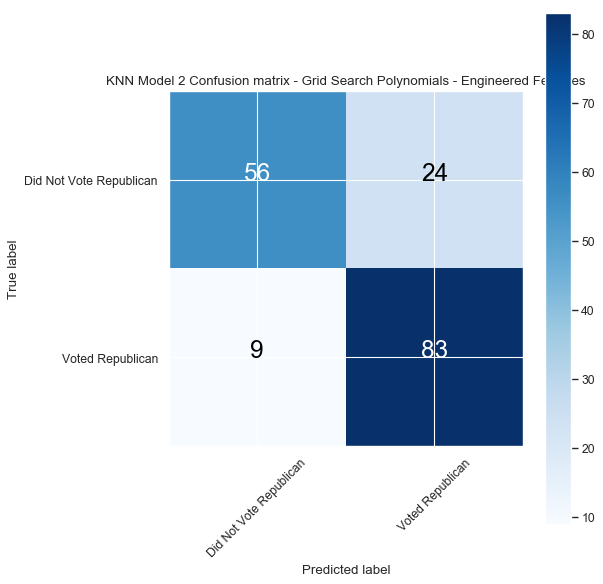

In [83]:
#Plots the confusin matrix
confusion_KNN_model_2 = metrics.confusion_matrix(y_test_KNN_model_2, y_pred_test_KNN_model_2)
plot_confusion_matrix(confusion_KNN_model_2, title='KNN Model 2 Confusion matrix - Grid Search Polynomials - Engineered Features')

## 13. A Function to Visualize Decision Trees

In [84]:
def plot_decision_tree(clf, feature_cols, class_titles, file_name):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names = class_titles)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    
    
    graph.write_png(file_name + '.png')
    
    return Image(graph.create_png())

## 14. Decision Trees - Standard Set

In [85]:
#Splits the data for the decision tree model using the standard features
X_train_DT_model_1, X_test_DT_model_1, y_train_DT_model_1, y_test_DT_model_1 =  reset_data()

sc_DT_model_1=StandardScaler()
X_train_scaled_DT_model_1= sc_DT_model_1.fit_transform(X_train_DT_model_1)
X_test_scaled_DT_model_1 = sc_DT_model_1.transform(X_test_DT_model_1)

In [86]:
# Create Decision Tree classifer object
DT_model_1 = DecisionTreeClassifier()
# Train Decision Tree Classifer
DT_model_1 = DT_model_1.fit(X_train_scaled_DT_model_1, y_train_DT_model_1)

In [87]:
# Predict on training data with best params
y_pred_train_DT_model_1 = DT_model_1.predict(X_train_scaled_DT_model_1)

#Predict the response for test dataset
y_pred_test_DT_model_1 = DT_model_1.predict(X_test_scaled_DT_model_1)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 1 (Standard Features):", accuracy_score(y_train_DT_model_1, y_pred_train_DT_model_1))
print("Training F1 Score for Decision Tree Model 1 (Standard Features):", f1_score(y_train_DT_model_1, y_pred_train_DT_model_1))
print("")
print("Testing Accuracy for Decision Tree Model 1 (Standard Features):", accuracy_score(y_test_DT_model_1, y_pred_test_DT_model_1))
print("Testing F1 Score for Decision Tree Model 1 (Standard Features):", f1_score(y_test_DT_model_1, y_pred_test_DT_model_1))

Training Accuracy for Decision Tree Model 1 (Standard Features): 1.0
Training F1 Score for Decision Tree Model 1 (Standard Features): 1.0

Testing Accuracy for Decision Tree Model 1 (Standard Features): 0.8837209302325582
Testing F1 Score for Decision Tree Model 1 (Standard Features): 0.8913043478260869


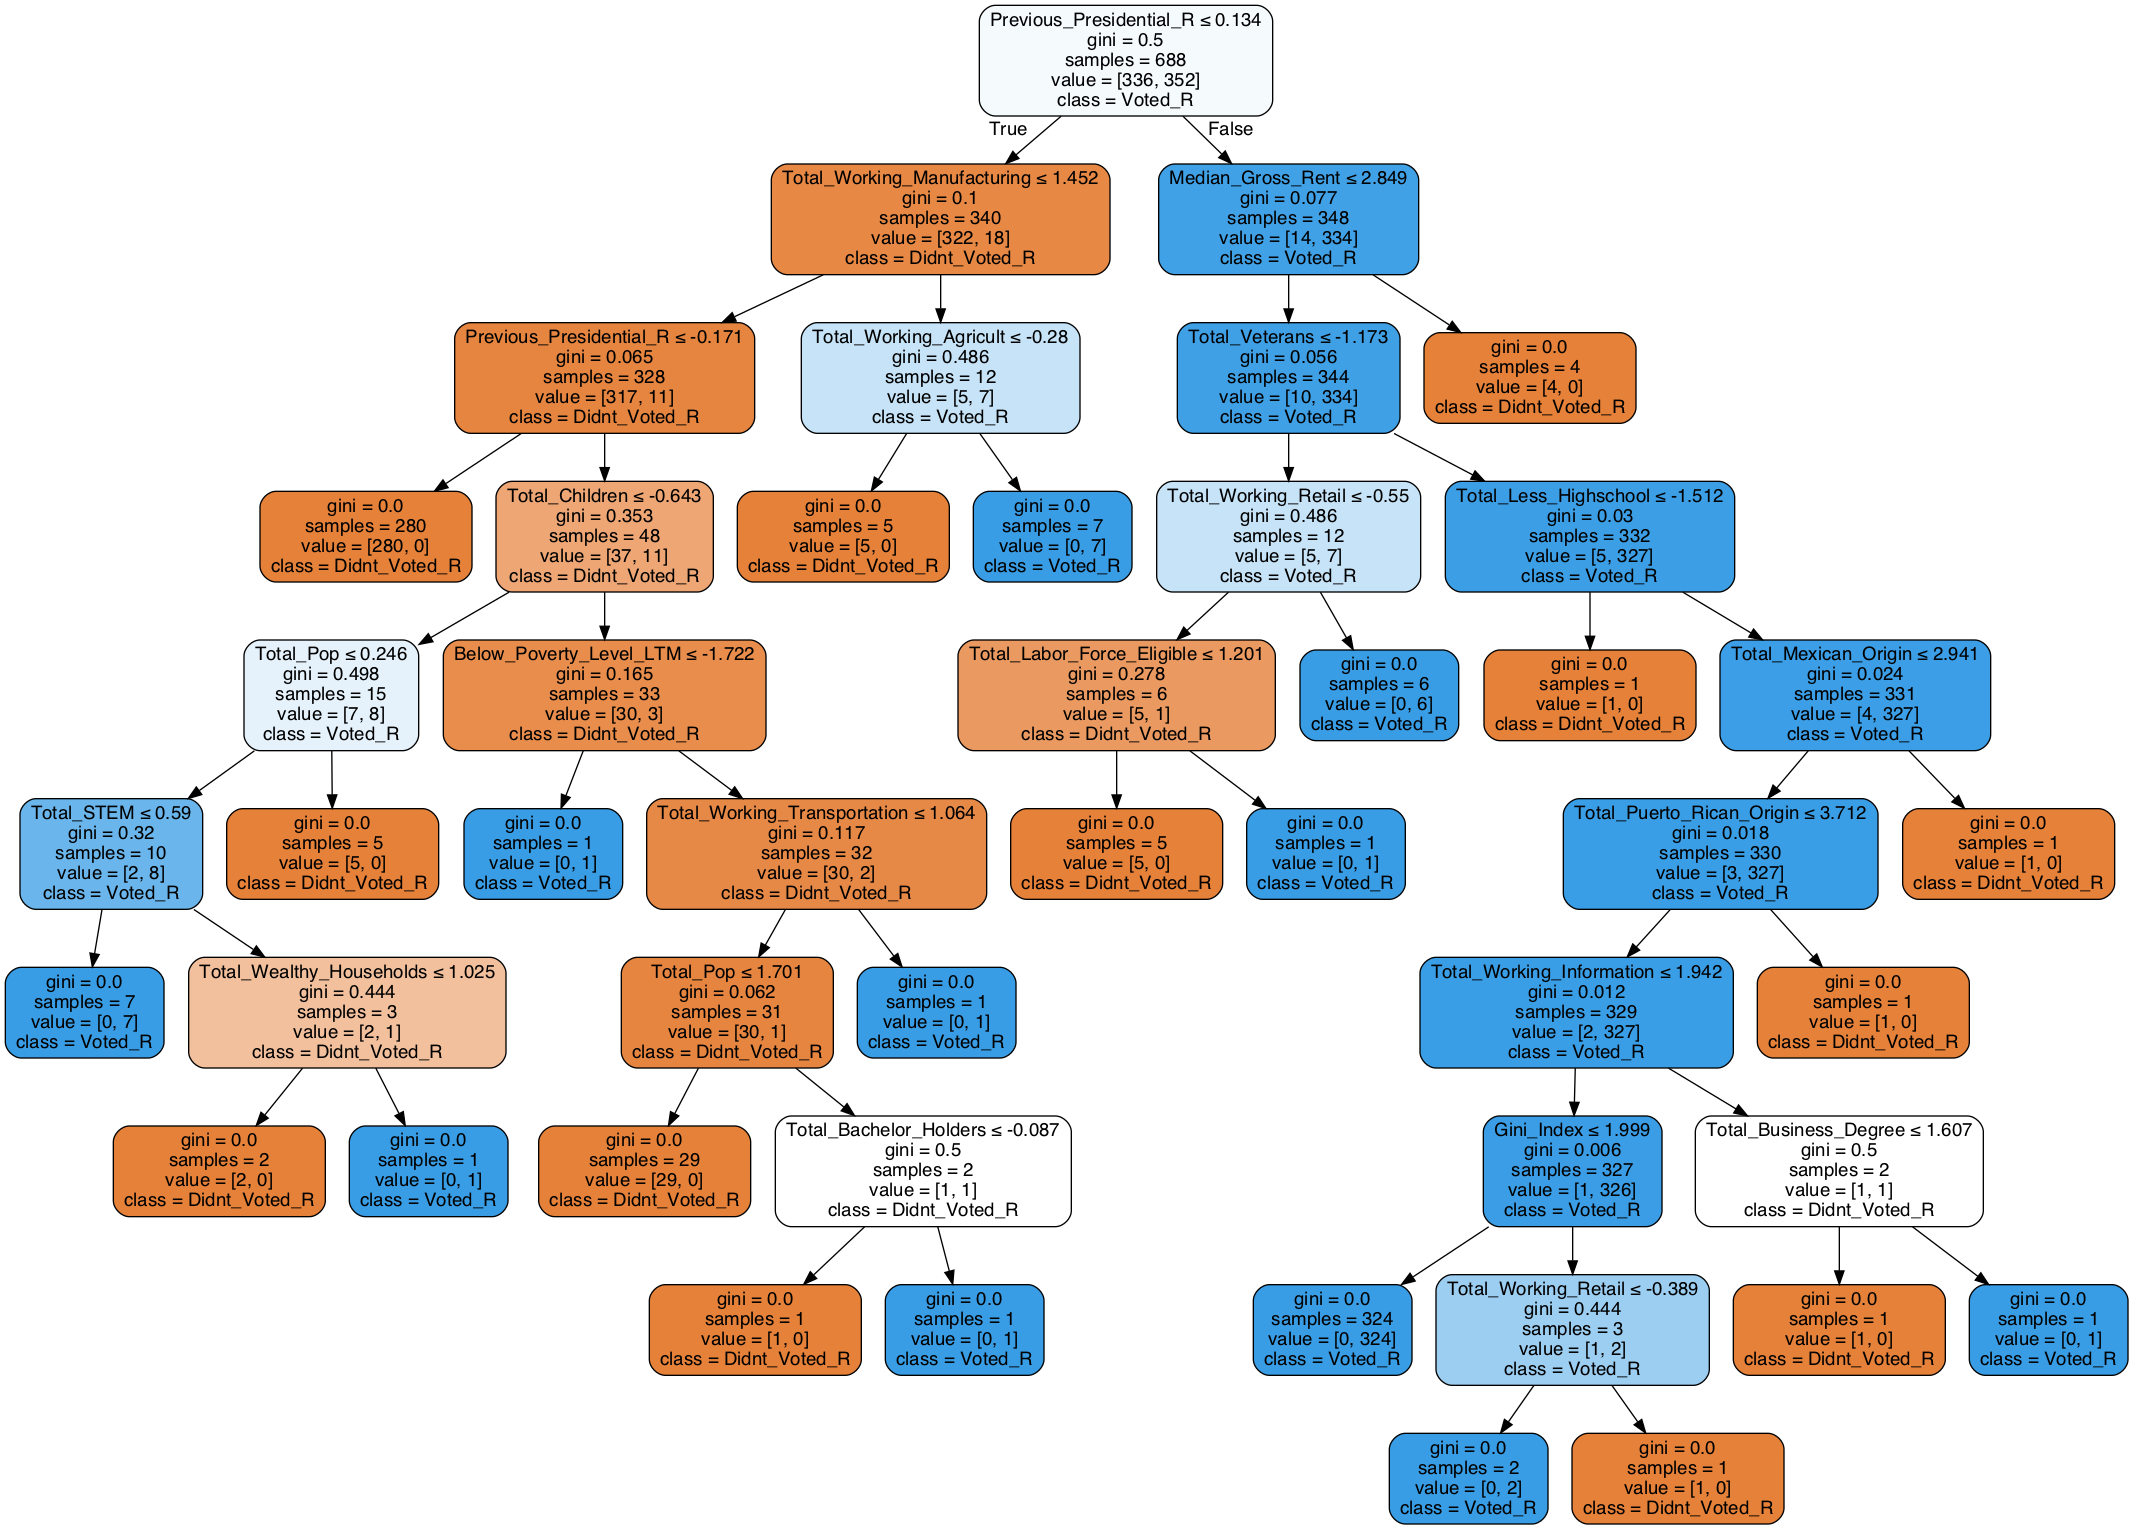

In [88]:
plot_decision_tree(DT_model_1, list(X_train_DT_model_1.columns), ['Didnt_Voted_R', 'Voted_R'], 'DT_model_1')

## 14. Decision Trees - Engineered Set


In [89]:
#Splits the data for the decision tree model using the engineered features
X_train_DT_model_2, X_test_DT_model_2, y_train_DT_model_2, y_test_DT_model_2 =  reset_data('engineered')

sc_DT_model_2=StandardScaler()
X_train_scaled_DT_model_2= sc_DT_model_2.fit_transform(X_train_DT_model_2)
X_test_scaled_DT_model_2 = sc_DT_model_2.transform(X_test_DT_model_2)

In [90]:
# Create Decision Tree classifer object
DT_model_2 = DecisionTreeClassifier()
# Train Decision Tree Classifer
DT_model_2 = DT_model_2.fit(X_train_scaled_DT_model_2, y_train_DT_model_2)

In [91]:
# Predict on training data with best params
y_pred_train_DT_model_2 = DT_model_2.predict(X_train_scaled_DT_model_2)

#Predict the response for test dataset
y_pred_test_DT_model_2 = DT_model_2.predict(X_test_scaled_DT_model_2)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 2 (Engineered Features):", accuracy_score(y_train_DT_model_2, y_pred_train_DT_model_2))
print("Training F1 Score for Decision Tree Model 2 (Engineered Features):", f1_score(y_train_DT_model_2, y_pred_train_DT_model_2))
print("")
print("Testing Accuracy for Decision Tree Model 2 (Engineered Features):", accuracy_score(y_test_DT_model_2, y_pred_test_DT_model_2))
print("Testing F1 Score for Decision Tree Model 2 (Engineered Features):", f1_score(y_test_DT_model_2, y_pred_test_DT_model_2))

Training Accuracy for Decision Tree Model 2 (Engineered Features): 1.0
Training F1 Score for Decision Tree Model 2 (Engineered Features): 1.0

Testing Accuracy for Decision Tree Model 2 (Engineered Features): 0.8895348837209303
Testing F1 Score for Decision Tree Model 2 (Engineered Features): 0.8961748633879782


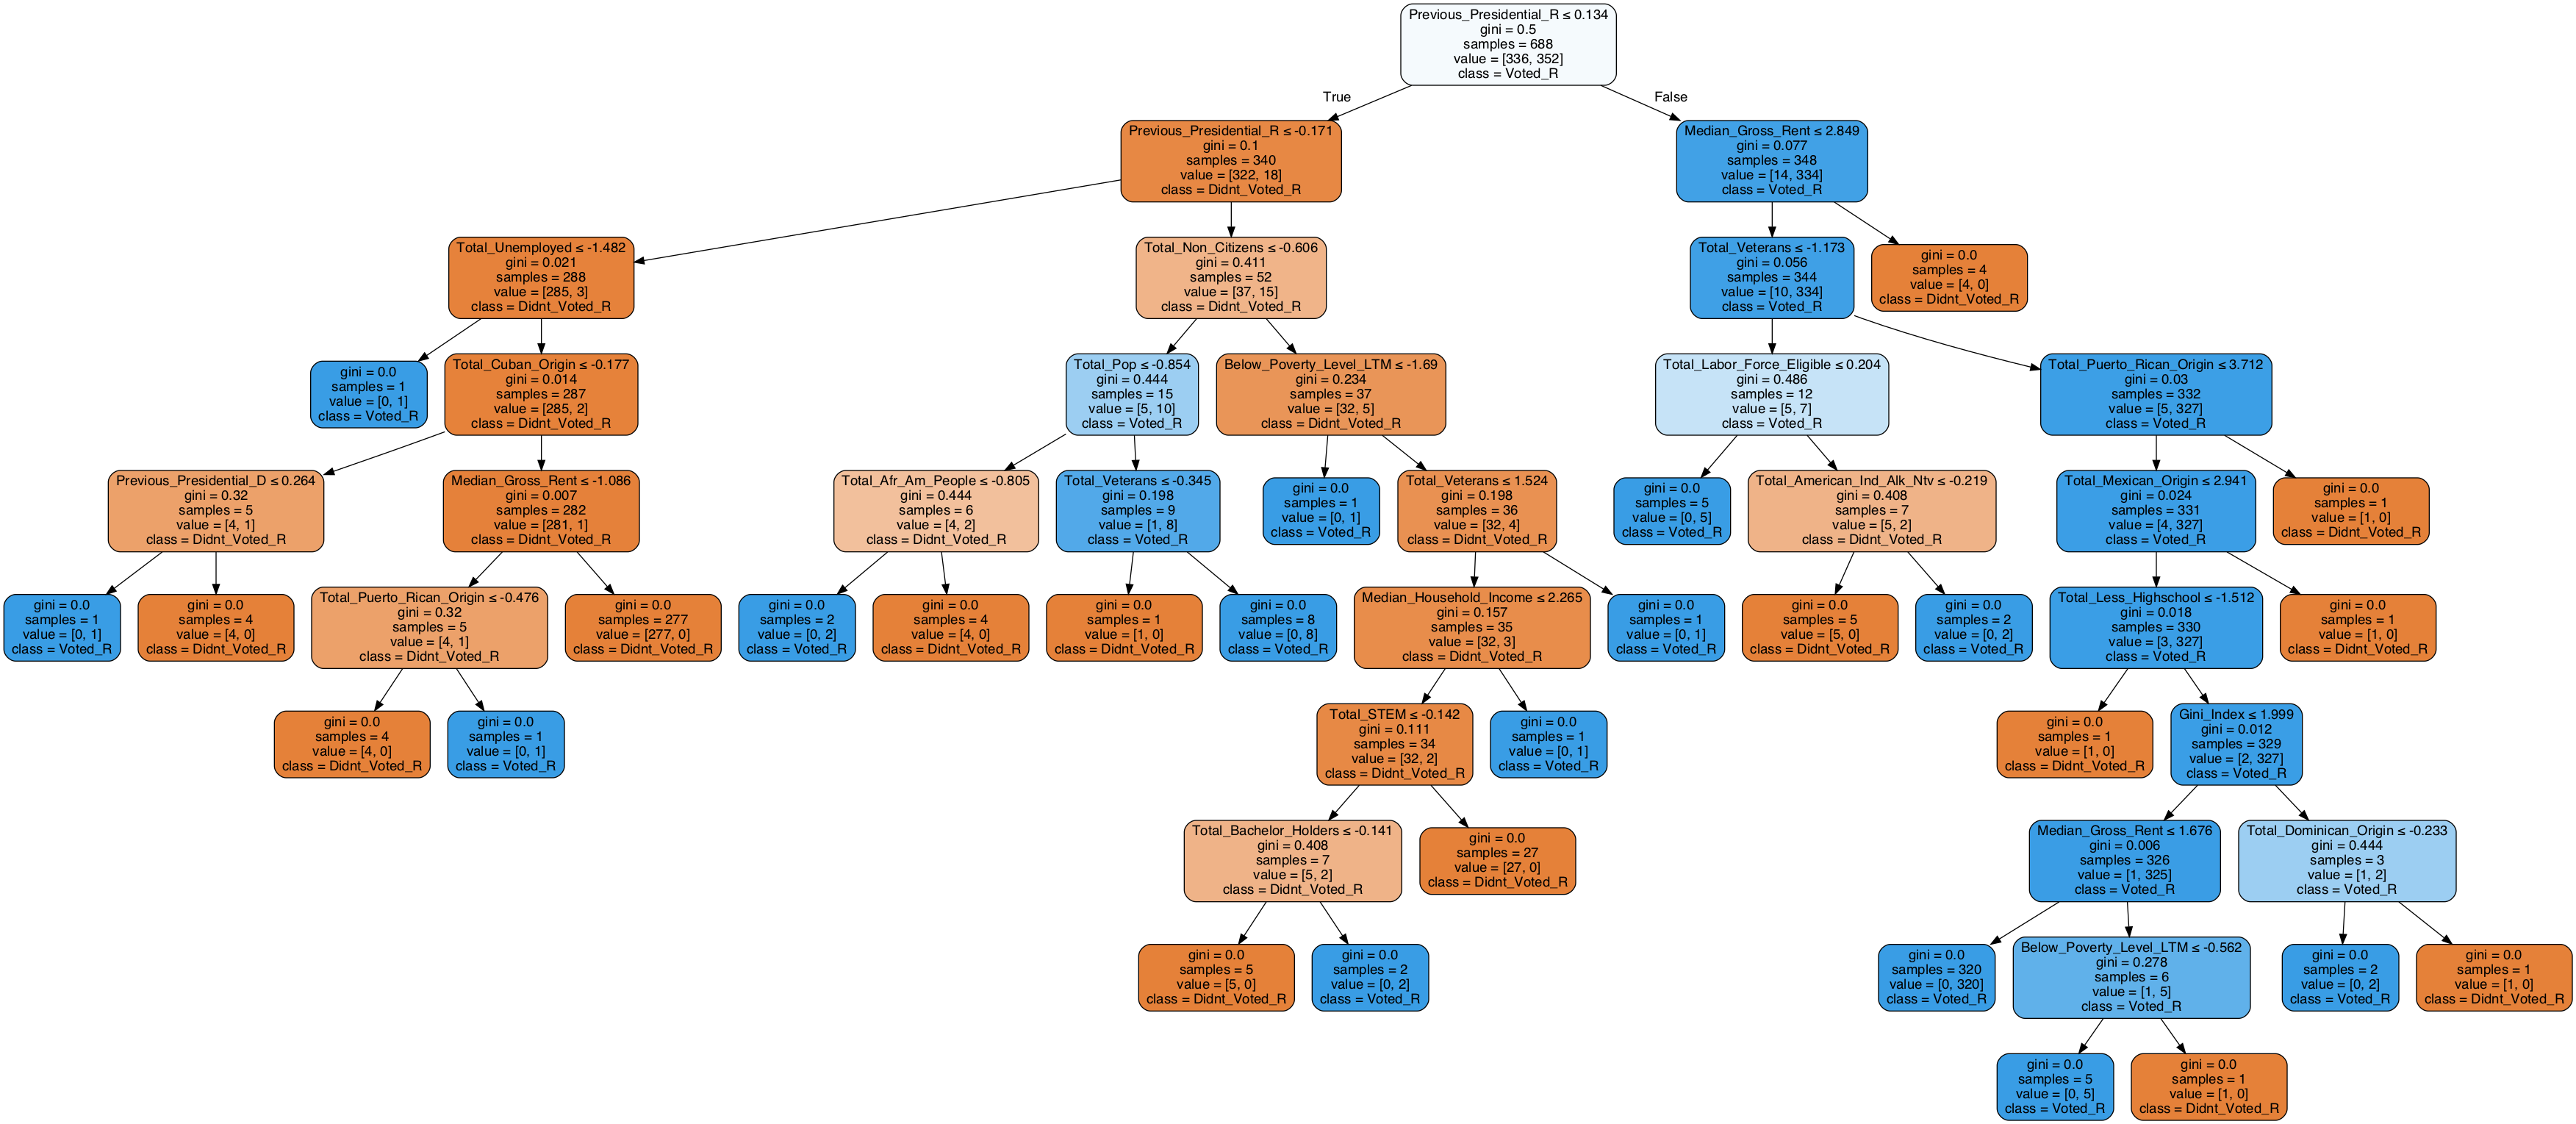

In [92]:
plot_decision_tree(DT_model_2, list(X_train_DT_model_2.columns), ['Didnt_Voted_R', 'Voted_R'], 'DT_model_2')

## 15. Decision Trees - Grid Search - Standard Set

In [93]:
#Splits the data for the decision tree model gridsearch, using the standard features
X_train_DT_model_3, X_test_DT_model_3, y_train_DT_model_3, y_test_DT_model_3 =  reset_data()

sc_DT_model_3=StandardScaler()
X_train_scaled_DT_model_3= sc_DT_model_3.fit_transform(X_train_DT_model_3)
X_test_scaled_DT_model_3 = sc_DT_model_3.transform(X_test_DT_model_3)

In [94]:
# The scorers used in the gridsearch to find the best parameters
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [95]:
#Parameters and model creation
parameters ={'criterion': ['gini','entropy'], 'min_samples_leaf' : range(5,100,15), 'max_depth': range(2,20,1)}

DT_model_3 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid= parameters,
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True)
#I've taken out the parameter 'verbose=5' to neaten up the notebook


In [96]:
DT_model_3.fit(X_train_scaled_DT_model_3, y_train_DT_model_3)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(5, 100, 15), 'max_depth': range(2, 20)},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=0)

In [97]:
# Predict on training data with best params
y_pred_train_DT_model_3 = DT_model_3.predict(X_train_scaled_DT_model_3)

#Predict the response for test dataset
y_pred_test_DT_model_3 = DT_model_3.predict(X_test_scaled_DT_model_3)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 3 GS (Standard Features):", accuracy_score(y_train_DT_model_3, y_pred_train_DT_model_3))
print("Training F1 Score for Decision Tree Model 3 GS (Standard Features):", f1_score(y_train_DT_model_3, y_pred_train_DT_model_3))
print("")
print("Testing Accuracy for Decision Tree Model 3 GS (Standard Features):", accuracy_score(y_test_DT_model_3, y_pred_test_DT_model_3))
print("Testing F1 Score for Decision Tree Model 3 GS (Standard Features):", f1_score(y_test_DT_model_3, y_pred_test_DT_model_3))

Training Accuracy for Decision Tree Model 3 GS (Standard Features): 0.9534883720930233
Training F1 Score for Decision Tree Model 3 GS (Standard Features): 0.9542857142857143

Testing Accuracy for Decision Tree Model 3 GS (Standard Features): 0.9186046511627907
Testing F1 Score for Decision Tree Model 3 GS (Standard Features): 0.9222222222222224


In [98]:
print('The top score for a decision tree is: ' + str(DT_model_3.best_score_))
print('The parameters for the top performing decision tree is: ' + str(DT_model_3.best_params_))
print('The top performing decision tree is: ')
print(DT_model_3.best_estimator_)

The top score for a decision tree is: 0.9819835684816581
The parameters for the top performing decision tree is: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 80}
The top performing decision tree is: 
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=80, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [99]:
DT_model_3.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_train_AUC', 'split1_train_AUC', 'split2_train_AUC', 'split3_train_AUC', 'split4_train_AUC', 'mean_train_AUC', 'std_train_AUC', 'split0_test_Accuracy', 'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy', 'split4_test_Accuracy', 'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy', 'split0_train_Accuracy', 'split1_train_Accuracy', 'split2_train_Accuracy', 'split3_train_Accuracy', 'split4_train_Accuracy', 'mean_train_Accuracy', 'std_train_Accuracy'])

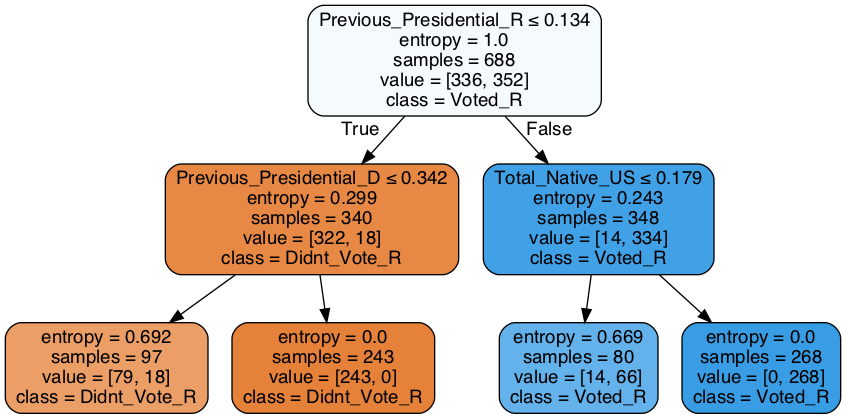

In [100]:
plot_decision_tree(DT_model_3.best_estimator_, list(X_train_DT_model_3.columns), ['Didnt_Vote_R', 'Voted_R'], 'DT_model_3')

## 16. Decision Trees - Grid Search - Engineered Set

In [101]:
#Splits the data for the decision tree model gridsearch, using the engineered features
X_train_DT_model_4, X_test_DT_model_4, y_train_DT_model_4, y_test_DT_model_4 =  reset_data('engineered')

sc_DT_model_4=StandardScaler()
X_train_scaled_DT_model_4= sc_DT_model_4.fit_transform(X_train_DT_model_4)
X_test_scaled_DT_model_4 = sc_DT_model_4.transform(X_test_DT_model_4)

In [102]:
#Parameters and model creation
parameters ={'criterion': ['gini','entropy'], 'min_samples_leaf' : range(5,100,15), 'max_depth': range(2,20,1)}

DT_model_4 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid= parameters,
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True)
#I've taken out the parameter 'verbose=5' to neaten up the notebook

In [103]:
DT_model_4.fit(X_train_scaled_DT_model_4, y_train_DT_model_4)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(5, 100, 15), 'max_depth': range(2, 20)},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=0)

In [104]:
# Predict on training data with best params
y_pred_train_DT_model_4 = DT_model_4.predict(X_train_scaled_DT_model_4)

#Predict the response for test dataset
y_pred_test_DT_model_4 = DT_model_4.predict(X_test_scaled_DT_model_4)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 4 GS (Engineered Features):", accuracy_score(y_train_DT_model_4, y_pred_train_DT_model_4))
print("Training F1 Score for Decision Tree Model 4 GS (Engineered Features):", f1_score(y_train_DT_model_4, y_pred_train_DT_model_4))
print("")
print("Testing Accuracy for Decision Tree Model 4 GS (Engineered Features):", accuracy_score(y_test_DT_model_4, y_pred_test_DT_model_4))
print("Testing F1 Score for Decision Tree Model 4 GS (Engineered Features):", f1_score(y_test_DT_model_4, y_pred_test_DT_model_4))

Training Accuracy for Decision Tree Model 4 GS (Engineered Features): 0.9549418604651163
Training F1 Score for Decision Tree Model 4 GS (Engineered Features): 0.9571230982019364

Testing Accuracy for Decision Tree Model 4 GS (Engineered Features): 0.9069767441860465
Testing F1 Score for Decision Tree Model 4 GS (Engineered Features): 0.9157894736842105


In [105]:
print('The top score for a decision tree is: ' + str(DT_model_4.best_score_))
print('The parameters for the top performing decision tree is: ' + str(DT_model_4.best_params_))
print('The top performing decision tree is: ')
print(DT_model_4.best_estimator_)

The top score for a decision tree is: 0.9810987702764765
The parameters for the top performing decision tree is: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}
The top performing decision tree is: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


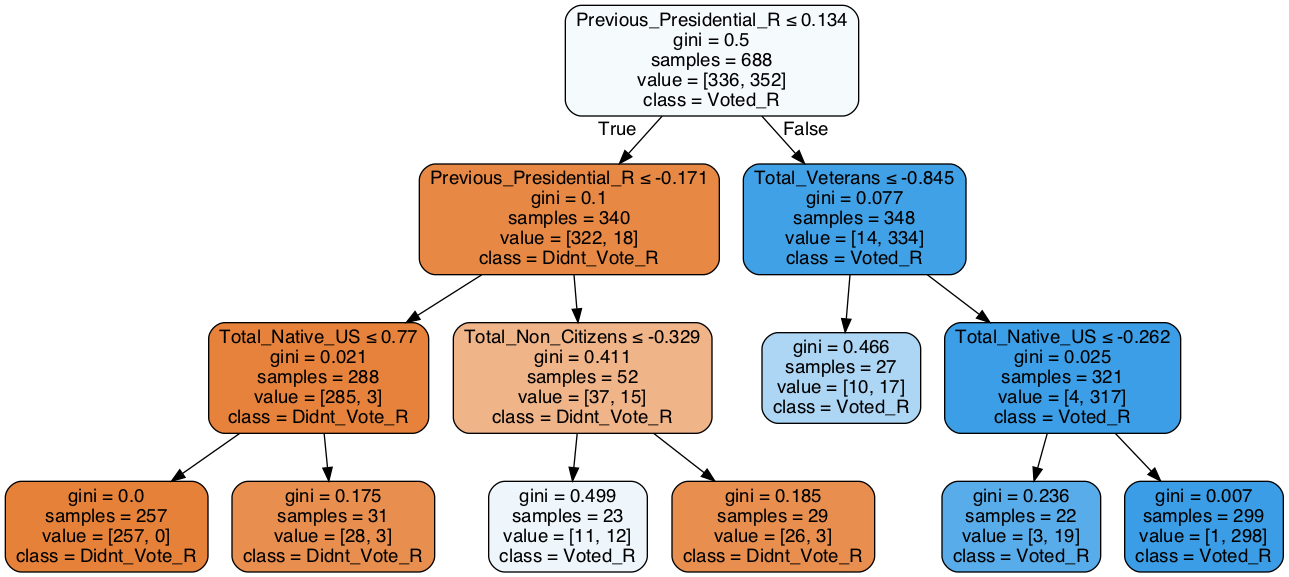

In [106]:
plot_decision_tree(DT_model_4.best_estimator_, list(X_train_DT_model_4.columns), ['Didnt_Vote_R', 'Voted_R'], 'DT_model_4')

## 17. Random Forest - Standard Set

In [107]:
#Creates the parameters for the random forest model
param_grid = { 
    'n_estimators': [200,300,400],
    'max_features': [0.25, 0.33, 0.5 ],
    'max_depth' : [5,6,7,8,9],
    'min_samples_leaf': [0.03,0.04,0.05,0.06]
}

In [108]:
#Splits the data for the random forest model using the standard features
X_train_rfc_model_1, X_test_rfc_model_1, y_train_rfc_model_1, y_test_rfc_model_1 =  reset_data()

sc_rfc_model_1=StandardScaler()
X_train_scaled_rfc_model_1= sc_rfc_model_1.fit_transform(X_train_rfc_model_1)
X_test_scaled_rfc_model_1 = sc_rfc_model_1.transform(X_test_rfc_model_1)

In [109]:
#Fits the rf model
rfc_model_1 = GridSearchCV(estimator= RandomForestClassifier(random_state = 23), param_grid=param_grid, cv= 5, n_jobs=-1)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
rfc_model_1.fit(X_train_scaled_rfc_model_1, y_train_rfc_model_1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 300, 400], 'max_features': [0.25, 0.33, 0.5], 'max_depth': [5, 6, 7, 8, 9], 'min_samples_leaf': [0.03, 0.04, 0.05, 0.06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
#Loading the saved random forest model with pickle
#rfc_model_1_pkl = open('./Classification_Models_After_rfc_model_1.pkl', 'rb')
#rfc_model_1 = pickle.load(rfc_model_1_pkl)
#print("Loaded rfc_model_1 Pickle :: ", rfc_model_1)
#print(rfc_model_1.best_estimator_.get_params())

In [110]:
# Predict on training data with best params
pred_rfc_model_1_train = rfc_model_1.predict(X_train_scaled_rfc_model_1)
#Predict the response for test dataset
pred_rfc_model_1 = rfc_model_1.predict(X_test_scaled_rfc_model_1)

In [111]:
# Prints the accuracy and f1 scores
print("Training Accuracy for Random Forest Model 1 (Standard Features):", accuracy_score(y_train_rfc_model_1, pred_rfc_model_1_train))
print("Training F1 Score for Random Forest Model 1 (Standard Features):", f1_score(y_train_rfc_model_1, pred_rfc_model_1_train))
print("")
print("Testing Accuracy for Random Forest Model 1 (Standard Features):", accuracy_score(y_test_rfc_model_1, pred_rfc_model_1))
print("Testing F1 Score for Random Forest Model 1 (Standard Features):", f1_score(y_test_rfc_model_1, pred_rfc_model_1))

Training Accuracy for Random Forest Model 1 (Standard Features): 0.9578488372093024
Training F1 Score for Random Forest Model 1 (Standard Features): 0.9586305278174038

Testing Accuracy for Random Forest Model 1 (Standard Features): 0.9302325581395349
Testing F1 Score for Random Forest Model 1 (Standard Features): 0.934065934065934


In [112]:
print('The top score for a random forest is: ' + str(rfc_model_1.best_score_))
print('The parameters for the top performing random forest is: ' + str(rfc_model_1.best_params_))
print('The top performing random forest is: ')
print(rfc_model_1.best_estimator_)

The top score for a random forest is: 0.9520348837209303
The parameters for the top performing random forest is: {'max_depth': 5, 'max_features': 0.25, 'min_samples_leaf': 0.03, 'n_estimators': 200}
The top performing random forest is: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.03, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)


In [113]:
#Run this code to save the random forest model data
#make_pickle(rfc_model_1, 'rfc_model_1')

## 18. Random Forest - Engineered Set

In [114]:
#Splits the data for the random forest model using the engineered features
X_train_rfc_model_2, X_test_rfc_model_2, y_train_rfc_model_2, y_test_rfc_model_2 =  reset_data('engineered')

sc_rfc_model_2=StandardScaler()
X_train_scaled_rfc_model_2= sc_rfc_model_2.fit_transform(X_train_rfc_model_2)
X_test_scaled_rfc_model_2 = sc_rfc_model_2.transform(X_test_rfc_model_2)

In [115]:
#Fits the rf model
rfc_model_2 = GridSearchCV(estimator= RandomForestClassifier(random_state = 23), param_grid=param_grid, cv= 5, n_jobs=-1)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
rfc_model_2.fit(X_train_scaled_rfc_model_2, y_train_rfc_model_2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 300, 400], 'max_features': [0.25, 0.33, 0.5], 'max_depth': [5, 6, 7, 8, 9], 'min_samples_leaf': [0.03, 0.04, 0.05, 0.06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
#Loading the saved random forest smote model with pickle
#rfc_model_2_pkl = open('./Classification_Models_After_rfc_model_2.pkl', 'rb')
#rfc_model_2 = pickle.load(rfc_model_2_pkl)
#print("Loaded rfc_model_2 Pickle :: ", rfc_model_2)
#print(rfc_model_2.best_estimator_.get_params())

In [116]:
# Predict on training data with best params
pred_rfc_model_2_train = rfc_model_2.predict(X_train_scaled_rfc_model_2)
#Predict the response for test dataset
pred_rfc_model_2 = rfc_model_2.predict(X_test_scaled_rfc_model_2)

In [117]:
# Prints the accuracy and f1 scores
print("Training Accuracy for Random Forest Model 2 (Engineered Features):", accuracy_score(y_train_rfc_model_2, pred_rfc_model_2_train))
print("Training F1 Score for Random Forest Model 2 (Engineered Features):", f1_score(y_train_rfc_model_2, pred_rfc_model_2_train))
print("")
print("Testing Accuracy for Random Forest Model 2 (Engineered Features):", accuracy_score(y_test_rfc_model_2, pred_rfc_model_2))
print("Testing F1 Score for Random Forest Model 2 (Engineered Features):", f1_score(y_test_rfc_model_2, pred_rfc_model_2))

Training Accuracy for Random Forest Model 2 (Engineered Features): 0.9563953488372093
Training F1 Score for Random Forest Model 2 (Engineered Features): 0.9571428571428571

Testing Accuracy for Random Forest Model 2 (Engineered Features): 0.9302325581395349
Testing F1 Score for Random Forest Model 2 (Engineered Features): 0.934065934065934


In [118]:
print('The top score for a random forest is: ' + str(rfc_model_2.best_score_))
print('The parameters for the top performing random forest is: ' + str(rfc_model_2.best_params_))
print('The top performing random forest is: ')
print(rfc_model_2.best_estimator_)

The top score for a random forest is: 0.9534883720930233
The parameters for the top performing random forest is: {'max_depth': 5, 'max_features': 0.25, 'min_samples_leaf': 0.04, 'n_estimators': 300}
The top performing random forest is: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.04, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)


In [119]:
#Run this code to save the random forest model data
#make_pickle(rfc_model_2, 'rfc_model_2')

## 19. XGBoost - Standard Set

In [120]:
X_train_xgb_model_1, X_test_xgb_model_1, y_train_xgb_model_1, y_test_xgb_model_1 =  reset_data()

sc_xgb_model_1 = StandardScaler()
X_train_scaled_xgb_model_1= sc_xgb_model_1.fit_transform(X_train_xgb_model_1)
X_test_scaled_xgb_model_1 = sc_xgb_model_1.transform(X_test_xgb_model_1)

In [121]:
#fits and then scores the XGBoost model
xgb_model_1 = xgb.XGBClassifier()
xgb_model_1.fit(X_train_scaled_xgb_model_1, y_train_xgb_model_1)

training_preds_xgb_model_1 = xgb_model_1.predict(X_train_scaled_xgb_model_1)
val_preds_xgb_model_1 = xgb_model_1.predict(X_test_scaled_xgb_model_1)

training_accuracy_xgb_model_1 = accuracy_score(y_train_xgb_model_1, training_preds_xgb_model_1)
val_accuracy_xgb_model_1 = accuracy_score(y_test_xgb_model_1, val_preds_xgb_model_1)

print("Training Accuracy for the standard model: {:.4}%".format(training_accuracy_xgb_model_1 * 100))
print("Validation Accuracy for the standard model: {:.4}%".format(val_accuracy_xgb_model_1 * 100))

Training Accuracy for the standard model: 100.0%
Validation Accuracy for the standard model: 93.02%


In [122]:
#Creates a parameter grid for the gridsearch of XGBoost
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [123]:
#Creates an XGBoost model
xgb_model_1 = xgb.XGBClassifier()

In [124]:
#Fits the data to the model
xgb_model_1 = GridSearchCV(xgb_model_1, param_grid, scoring='accuracy', cv=None, n_jobs=1)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
xgb_model_1.fit(X_train_scaled_xgb_model_1, y_train_xgb_model_1)

GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'learning_rate': [0.1], 'max_depth': [6], 'min_child_weight': [10], 'subsample': [0.7], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [125]:
#Prints the best parameters from the XGBoost model
best_parameters_xgb_model_1 = xgb_model_1.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters_xgb_model_1.keys()):
    print("%s: %r" % (param_name, best_parameters_xgb_model_1[param_name]))

training_preds_xgb_model_1 = xgb_model_1.predict(X_train_scaled_xgb_model_1)
val_preds_xgb_model_1 = xgb_model_1.predict(X_test_scaled_xgb_model_1)
training_accuracy_xgb_model_1 = accuracy_score(y_train_xgb_model_1, training_preds_xgb_model_1)
val_accuracy_xgb_model_1 = accuracy_score(y_test_xgb_model_1, val_preds_xgb_model_1)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb_model_1 * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_xgb_model_1 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 30
subsample: 0.7

Training Accuracy: 95.64%
Validation accuracy: 92.44%


In [126]:
#Makes predictions for model scoring
y_pred_train_xgb_model_1 = xgb_model_1.predict(X_train_scaled_xgb_model_1)
y_pred_test_xgb_model_1 = xgb_model_1.predict(X_test_scaled_xgb_model_1)

# Prints the accuracy and f1 scores
print('Training Accuracy for XGBoost Model 1 (Standard Features): %.4f ' % accuracy_score(y_train_xgb_model_1, y_pred_train_xgb_model_1))
print('Training F1 Score for XGBoost Model 1 (Standard Features): %.4f ' % f1_score(y_train_xgb_model_1, y_pred_train_xgb_model_1))
print('')
print('Testing Accuracy for XGBoost Model 1 (Standard Features): %.4f ' % accuracy_score(y_test_xgb_model_1, y_pred_test_xgb_model_1))
print('Testing F1 Score for XGBoost Model 1 (Standard Features): %.4f ' % f1_score(y_test_xgb_model_1, y_pred_test_xgb_model_1))

Training Accuracy for XGBoost Model 1 (Standard Features): 0.9564 
Training F1 Score for XGBoost Model 1 (Standard Features): 0.9574 

Testing Accuracy for XGBoost Model 1 (Standard Features): 0.9244 
Testing F1 Score for XGBoost Model 1 (Standard Features): 0.9297 


## 20. XGBoost - Engineered Set

In [127]:
X_train_xgb_model_2, X_test_xgb_model_2, y_train_xgb_model_2, y_test_xgb_model_2 =  reset_data('engineered')

sc_xgb_model_2 = StandardScaler()
X_train_scaled_xgb_model_2= sc_xgb_model_2.fit_transform(X_train_xgb_model_2)
X_test_scaled_xgb_model_2 = sc_xgb_model_2.transform(X_test_xgb_model_2)

In [128]:
#fits and then scores the XGBoost model
xgb_model_2 = xgb.XGBClassifier()
xgb_model_2.fit(X_train_scaled_xgb_model_2, y_train_xgb_model_2)

training_preds_xgb_model_2 = xgb_model_2.predict(X_train_scaled_xgb_model_2)
val_preds_xgb_model_2 = xgb_model_2.predict(X_test_scaled_xgb_model_2)

training_accuracy_xgb_model_2 = accuracy_score(y_train_xgb_model_2, training_preds_xgb_model_2)
val_accuracy_xgb_model_2 = accuracy_score(y_test_xgb_model_2, val_preds_xgb_model_2)

print("Training Accuracy for the standard model: {:.4}%".format(training_accuracy_xgb_model_2 * 100))
print("Validation Accuracy for the standard model: {:.4}%".format(val_accuracy_xgb_model_2 * 100))

Training Accuracy for the standard model: 100.0%
Validation Accuracy for the standard model: 90.7%


In [129]:
#Creates an XGBoost model
xgb_model_2 = xgb.XGBClassifier()

In [130]:
#Fits the data to the model
xgb_model_2 = GridSearchCV(xgb_model_2, param_grid, scoring='accuracy', cv=None, n_jobs=1)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
xgb_model_2.fit(X_train_scaled_xgb_model_2, y_train_xgb_model_2)

GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'learning_rate': [0.1], 'max_depth': [6], 'min_child_weight': [10], 'subsample': [0.7], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [131]:
#Prints the best parameters from the XGBoost model
best_parameters_xgb_model_2 = xgb_model_2.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters_xgb_model_2.keys()):
    print("%s: %r" % (param_name, best_parameters_xgb_model_2[param_name]))

training_preds_xgb_model_2 = xgb_model_2.predict(X_train_scaled_xgb_model_2)
val_preds_xgb_model_2 = xgb_model_2.predict(X_test_scaled_xgb_model_2)
training_accuracy_xgb_model_2 = accuracy_score(y_train_xgb_model_2, training_preds_xgb_model_2)
val_accuracy_xgb_model_2 = accuracy_score(y_test_xgb_model_2, val_preds_xgb_model_2)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb_model_2 * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_xgb_model_2 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 30
subsample: 0.7

Training Accuracy: 96.08%
Validation accuracy: 93.02%


In [132]:
#Makes predictions for model scoring
y_pred_train_xgb_model_2 = xgb_model_2.predict(X_train_scaled_xgb_model_2)
y_pred_test_xgb_model_2 = xgb_model_2.predict(X_test_scaled_xgb_model_2)

# Prints the accuracy and f1 scores
print('Training Accuracy for XGBoost Model 2 (Standard Features): %.4f ' % accuracy_score(y_train_xgb_model_2, y_pred_train_xgb_model_2))
print('Training F1 Score for XGBoost Model 2 (Standard Features): %.4f ' % f1_score(y_train_xgb_model_2, y_pred_train_xgb_model_2))
print('')
print('Testing Accuracy for XGBoost Model 2 (Standard Features): %.4f ' % accuracy_score(y_test_xgb_model_2, y_pred_test_xgb_model_2))
print('Testing F1 Score for XGBoost Model 2 (Standard Features): %.4f ' % f1_score(y_test_xgb_model_2, y_pred_test_xgb_model_2))

Training Accuracy for XGBoost Model 2 (Standard Features): 0.9608 
Training F1 Score for XGBoost Model 2 (Standard Features): 0.9618 

Testing Accuracy for XGBoost Model 2 (Standard Features): 0.9302 
Testing F1 Score for XGBoost Model 2 (Standard Features): 0.9348 
